#**Predicción de enfermedades mentales en personas que han cometido un tiroteo en masa**

Equipo 32:

Laura Elena Osuna Burgoin   arual672@gmail.com

Jocelyn Sosa Trejo          jocelynsotre@gmail.com

## 1. Importación de librerias, datasets y limpieza de datos

Se seleccionaron e importaron los conjuntos de
datos de tiroteos en estados unidos.

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_validate
import re
import nltk
from nltk.corpus import stopwords
import folium

### Dataset : Tiroteos en masa (1966-2022)

Contiene la descripción y diversos datos acerca de los tiroteos en masa en Estados Unidos (1966-2022). En este caso se optó por trabajar solamente con las categorias de lugar, descripción, total de víctimas, edad, raza, detalles de salud mental, género y año.  

In [ ]:
df_ms = pd.read_csv('https://github.com/LauraEle24/Proyecto-Tecnolochicas/raw/main/us_mass_shootings_may_24_2022.csv')
df_ms = df_ms.reset_index(drop=False)
df_ms = df_ms[['case', 'location', 'summary', 'total_victims', 'location.1', 'age_of_shooter', 'prior_signs_mental_health_issues', 'mental_health_details', 'race', 'gender', 'year']]
df_ms.head()

,case,location,summary,total_victims,location.1,age_of_shooter,prior_signs_mental_health_issues,mental_health_details,race,gender,year
0,Uvalde elementary school massacre,"Uvalde, Texas",DETAILS PENDING,-,School,18,-,-,-,M,2022
1,Buffalo supermarket massacre,"Buffalo, New York","Payton S. Gendron, 18, committed a racially mo...",13,workplace,18,yes,previous threats and a mental health evaluatio...,White,M,2022
2,Sacramento County church shooting,"Sacramento, California","""A man believed to be meeting his three childr...",4,Religious,-,-,-,-,M,2022
3,Oxford High School shooting,"Oxford, Michigan","Ethan Crumbley, a 15-year-old student at Oxfor...",11,School,15,-,-,-,M,2021
4,San Jose VTA shooting,"San Jose, California","Samuel Cassidy, 57, a Valley Transportation Au...",9,Workplace,57,yes,"Perpetrator had a history of depression, angry...",-,M,2021


#### Filtrado de datos para eliminar categorias repetitivas

* **Síntomas de enfermedades mentales**

In [ ]:
df_ms['prior_signs_mental_health_issues'].unique()

array(['-', 'yes', 'TBD', 'Yes', 'Unclear', 'Unknown', 'No', 'Unclear '],
      dtype=object)

In [ ]:
df_ms['prior_signs_mental_health_issues'] = df_ms['prior_signs_mental_health_issues'].replace('yes','Yes')
df_ms['prior_signs_mental_health_issues'] = df_ms['prior_signs_mental_health_issues'].replace('-','Unclear')
df_ms['prior_signs_mental_health_issues'] = df_ms['prior_signs_mental_health_issues'].replace('Unclear ','Unclear')
df_ms['prior_signs_mental_health_issues'] = df_ms['prior_signs_mental_health_issues'].replace('Unknown','Unclear')
df_ms['prior_signs_mental_health_issues'] = df_ms['prior_signs_mental_health_issues'].replace('TBD','Unclear')
df_ms['prior_signs_mental_health_issues'].unique()

array(['Unclear', 'Yes', 'No'], dtype=object)

In [ ]:
df_ms['prior_signs_mental_health_issues'].value_counts()

Yes        63
Unclear    48
No         17
Name: prior_signs_mental_health_issues, dtype: int64

* **Lugar del incidente**

In [ ]:
df_ms['location.1'].unique()

array(['School', 'workplace', 'Religious', 'Workplace', 'Other',
       'Military', 'Airport', '\nWorkplace', 'Other\n'], dtype=object)

In [ ]:
df_ms['location.1'] = df_ms['location.1'].replace('workplace','Workplace')
df_ms['location.1'] = df_ms['location.1'].replace('\nWorkplace','Workplace')
df_ms['location.1'] = df_ms['location.1'].replace('Other\n','Other')
df_ms['location.1'].unique()

array(['School', 'Workplace', 'Religious', 'Other', 'Military', 'Airport'],
      dtype=object)

* **Raza**

In [ ]:
df_ms['race'].unique()

array(['-', 'White', 'Black', 'Latino', 'Asian', 'Other', 'White ',
       'Native American', 'white', 'black', 'unclear'], dtype=object)

In [ ]:
df_ms['race'] = df_ms['race'].replace('-','Unclear')
df_ms['race'] = df_ms['race'].replace('unclear','Unclear')
df_ms['race'] = df_ms['race'].replace('white','White')
df_ms['race'] = df_ms['race'].replace('White ','White')
df_ms['race'] = df_ms['race'].replace('black','Black')
df_ms['race'].unique()

array(['Unclear', 'White', 'Black', 'Latino', 'Asian', 'Other',
       'Native American'], dtype=object)

* **Género**

In [ ]:
df_ms['gender'].unique()

array(['M', 'Male & Female', 'F', 'Male', 'Female'], dtype=object)

In [ ]:
df_ms['gender'] = df_ms['gender'].replace('Male','M')
df_ms['gender'] = df_ms['gender'].replace('Female','F')
df_ms['gender'].unique()

array(['M', 'Male & Female', 'F'], dtype=object)

* **Edad**

In [ ]:
df_ms['age_of_shooter'].unique()

array(['18', '-', '15', '57', '19', '21', '31', '51', '36', '24', '40',
       '45', '32', '28', '46', '26', '54', '29', '38', '17', '44', '47',
       '37', '64', '43', '39', '20', '25', '33', '27', '22', '34', '42',
       '23', '59', '41', '52', '16', '48', '66', '11', '35', '55', '50'],
      dtype=object)

In [ ]:
df_ms = df_ms.loc[df_ms['age_of_shooter'] != '-']

In [ ]:
df_ms['age_of_shooter'] = pd.to_numeric(df_ms['age_of_shooter'], errors='coerce')

<ipython-input-379-58e512f2e1bf>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
df_ms['total_victims'] = df_ms['total_victims'].replace('-', 0)
df_ms['total_victims'] = pd.to_numeric(df_ms['total_victims'], errors='coerce')

<ipython-input-380-4302c9fbff97>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-380-4302c9fbff97>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



## 2. Estimados de Locación y Variabilidad
Con el fin de conocer la dispersión de los datos de tiroteos en masa, asi como la tendencia central de los mismos, se obtuvieron los estimados de locación y variabilidad de las tres variables numéricas más relevantes para el estudio: edad del tirador, año del incidente y número de victimas.

### Variable 1: *edad del tirador*


* **Promedio y la mediana.** Son estimados de locación que se utilizan de manera recurrente en estadística descriptiva, ya que permiten comprender la tendencia central de los datos. Sin embargo, hay diferencias entre ambos valores que permiten analizar los datos de interés de varias maneras.

  Una de estas diferencias es el hecho de que la media es más sensible a datos atípicos que la mediana. Por lo tanto, una manera rápida de saber si existen este tipo de valores es comparando ambas medidas y analizando qué tan diferentes son.

  En este caso se puede observar que la media aritmética y la mediana son muy
similares entre si, por lo que en un primer vistazo se puede intuir que no hay tantos valores atípicos.

In [ ]:
# Promedio
df_ms['age_of_shooter'].mean()

33.74193548387097

In [ ]:
# Mediana
df_ms['age_of_shooter'].median()

33.5

* **Media truncada.** Tomando en cuenta que no hay presencia representativa de valores atípicos no es tan necesario realizar la media truncada, por lo que se optó por omitir dicho cálculo.

* **Rango**. Permite conocer que tan dispersos están los datos de interés. En este caso se puede observar que las personas analizadas son de edades significativamente variables, ya que la diferencia de edad es de 55 años.

In [ ]:
# Rango
df_ms['age_of_shooter'].max() - df_ms['age_of_shooter'].min()

55

* **Desviación estándar.** Además, se obtuvo la desviación estándar para determinar que tan dispersos se encuentran los datos con respecto a la media.

  En este caso, el resultado de 12.30 indica que en promedio cada edad individual varia en 12.3 unidades con respecto a la media aritmética. Así pues, esto implica que existe una variabilidad significativa en las edades que tienen las personas que han realizado un tiroteo en masa.


In [ ]:
# Desviación estándar
df_ms['age_of_shooter'].std()

12.300354260046053

* **Rango intercuartil.** Permite conocer la variabilidad de los datos con una sensibilidad menor a datos atipicos que el rango, ya que se utilizan los valores de percentiles 25 y 75 (cercanos a la media).

  El rango intercuartil obtenido indica una variabilidad significativa de los datos, ya que no es un valor cercano a cero.

In [ ]:
# Percentiles 25
q_1 = np.percentile(df_ms['age_of_shooter'], 25)
q_1

23.75

In [ ]:
# Percentil 75
q_3 = np.percentile(df_ms['age_of_shooter'], 75)
q_3

42.25

In [ ]:
# Rango intercuartil
q_3 - q_1

18.5

### Variable 2: *año del incidente*



En el caso de esta variable, se obtuvo un rango de 40 años (total de años estudiados en el dataframe), una tendencia central de los datos hacia el año 2012 y una variabilidad menor pero aún significativa con respecto a la variable 1.

In [ ]:
# Promedio
df_ms['year'].mean()

2008.8145161290322

In [ ]:
# Mediana
df_ms['year'].median()

2012.5

In [ ]:
# Media truncada
stats.trim_mean(df_ms['year'], .2)

2011.0657894736842

In [ ]:
# Rango
df_ms['year'].max() - df_ms['year'].min()

40

In [ ]:
# Desviación estándar
df_ms['year'].std()

10.579445430532921

In [ ]:
# Percentiles 25
q_1 = np.percentile(df_ms['year'], 25)
q_1

1999.75

In [ ]:
# Percentil 75
q_3 = np.percentile(df_ms['year'], 75)
q_3

2017.0

In [ ]:
# Rango intercuartil
q_3 - q_1

17.25

### Variable 3: *número de víctimas*

Al analizar el número de víctimas, se pudo observar una mayor diferencia entre la media y la mediana, lo cual puede indicar la presencia de datos atipicos.

Asimismo, se obtuvo un rango y desviación estándar mucho mayores, las cuales implican una mayor variabilidad y dispersión de los datos. Esto puede ser provocado por los datos atípicos presentes en esta categoria.

In [ ]:
# Promedio
df_ms['total_victims'].mean()

19.75

In [ ]:
# Mediana
df_ms['total_victims'].median()

10.0

In [ ]:
# Rango
df_ms['total_victims'].max() - df_ms['total_victims'].min()

604

In [ ]:
# Media truncada
stats.trim_mean(df_ms['total_victims'], .1)

12.37

In [ ]:
# Desviación estándar
df_ms['total_victims'].std()

54.93612329129552

In [ ]:
# Percentiles 25
q_1 = np.percentile(df_ms['total_victims'], 25)
q_1

6.75

In [ ]:
# Percentil 75
q_3 = np.percentile(df_ms['total_victims'], 75)
q_3

17.25

In [ ]:
# Rango intercuartil
q_3 - q_1

10.5

---

## 3. Visualización de datos: Distribuciones

Se elaboraron boxplots, tablas de frecuencia, histogramas y graficos de densidad para poder analizar de manera visual la tendencia de los datos y después filtrar aquellos que dificultan el correcto análisis de los datos.



### Variable 1: *edad del tirador*

* **Boxplot.** Sirve para tener una representación visual de los datos e identificar datos atipicos.
En cuanto a la variable de edad el resultado coincide con el analisis realizado con la media y mediana, ya que no se observan datos atipicos y la tendencia central esta alrededor de los 33 años.

[Text(0.5, 0, 'Edad')]

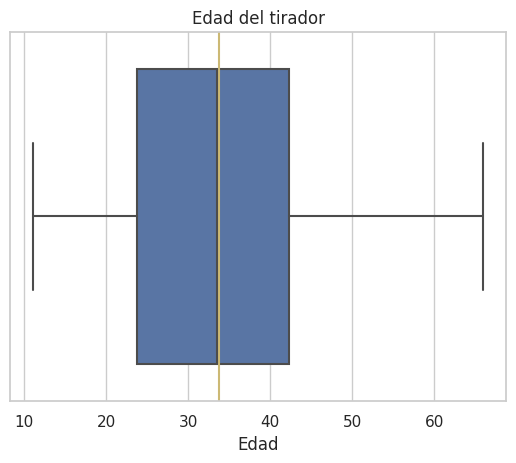

In [ ]:
# boxplot
sns.set(style="whitegrid")
ax = sns.boxplot(x=df_ms["age_of_shooter"])
plt.axvline(df_ms["age_of_shooter"].mean(), c='y')
plt.title('Edad del tirador')
ax.set(xlabel='Edad')

* **Rango intercuartilico (IQR).** Otra forma de encontrar los valores atípicos es mediante el rango intercuartilico, donde se toman como atipicos los datos que exceden en 1.5 veces el IQR.
El resultado fue un valor minimo aceptable de -4 y máximo de 70, valores que estan fuera de los limites de los datos, por lo que no hay observaciones anómalas y no es necesario filtrar la información.

In [ ]:
# identificando valores atipicos con IQR
resumen_est = df_ms['age_of_shooter'].describe()
iqr_edad = resumen_est['75%'] - resumen_est['25%']
score_iqr = 1.5 * iqr_edad
valor_min = resumen_est['25%'] - score_iqr
valor_min

-4.0

In [ ]:
valor_max = resumen_est['75%'] + score_iqr
valor_max

70.0

* **Tabla de frecuencias.** Con el fin de conocer la frecuencia de los valores, se llevó a cabo una tabla agrupando los datos en 10 segmentos.
Como resultado, el grupo de 16-22 y 38-44 años fueron los mayores con 24 y 25 incidentes relacionados a personas en esos rangos de edad.

In [ ]:
# Tabla de frecuencias
segmentos = pd.cut(df_ms['age_of_shooter'], 10)
df_ms['age_of_shooter'].groupby(segmentos).count()

age_of_shooter
(10.945, 16.5]     5
(16.5, 22.0]      24
(22.0, 27.5]      17
(27.5, 33.0]      16
(33.0, 38.5]      15
(38.5, 44.0]      25
(44.0, 49.5]       9
(49.5, 55.0]       6
(55.0, 60.5]       4
(60.5, 66.0]       3
Name: age_of_shooter, dtype: int64

* **Histograma.** Se realizó este gráfico para analizar de forma visual la frecuencia de los datos. Se puede notar que el resultado coincide con la tabla anteriormente realizada.

[Text(0.5, 0, 'Edad'), Text(0, 0.5, 'Frecuencia')]

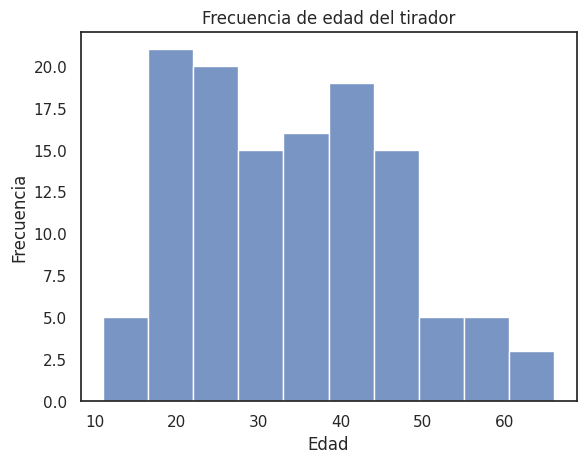

In [ ]:
# Histograma
sns.set(style="white")
ax = sns.histplot(df_ms['age_of_shooter'], bins=10)
plt.title('Frecuencia de edad del tirador')
ax.set(xlabel='Edad', ylabel='Frecuencia')

* **Asimetria y curtosis.** Sirven para describir la distribución de los datos. En este caso ambos son valores cercanos a cero, por lo que puede observarse una distribución muy similiar a la distribución normal.

In [ ]:
from scipy.stats import skew, kurtosis

In [ ]:
skew(df_ms['age_of_shooter']) # asimetria

0.4362268678804193

In [ ]:
kurtosis(df_ms['age_of_shooter']) # curtosis

-0.4722324187360645

* **Gráfica de densidad.** De manera similar al histograma, permite observar la distribución de los datos. Como resultado, los datos se concentran más en el rango de 20-40 años.

[Text(0.5, 0, 'Edad'),
 Text(0, 0.5, 'Densidad'),
 Text(0.5, 1.0, 'Frecuencia de edad del tirador')]

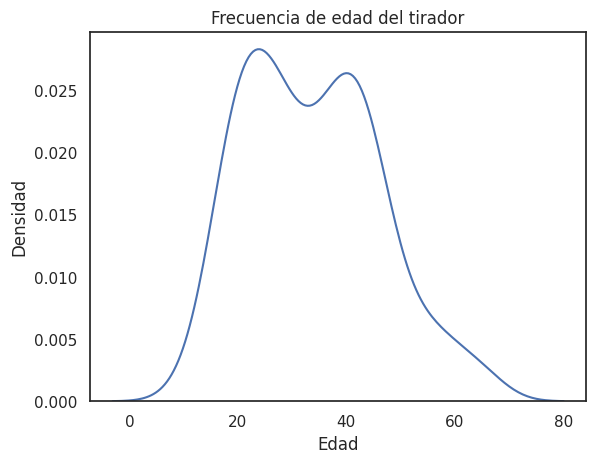

In [ ]:
ax = sns.kdeplot(df_ms['age_of_shooter'])
ax.set(xlabel='Edad', ylabel='Densidad', title = 'Frecuencia de edad del tirador')

### Variable 2: *año del incidente*

Al analizar la distribución del año de cada incidente, se pudo observar que tampoco hay valores atipicos significativos, por lo que no fue necesario filtrar los datos.

Por otro lado, el histograma, la gráfica de densidad y el cálculo de curtosis y asimetria, mostraron una tendencia hacia la izquierda (negativa) y ligeramente achatada (negativa).

[Text(0.5, 0, 'Año')]

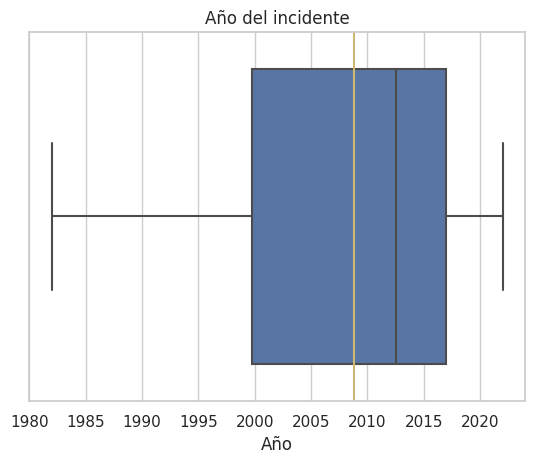

In [ ]:
# boxplot
sns.set(style="whitegrid")
ax = sns.boxplot(x=df_ms["year"])
plt.axvline(df_ms['year'].mean(), c='y')
plt.title('Año del incidente')
ax.set(xlabel='Año')

In [ ]:
resumen_est = df_ms['year'].describe()
iqr_edad = resumen_est['75%'] - resumen_est['25%']
score_iqr = 1.5 * iqr_edad
valor_min = resumen_est['25%'] - score_iqr
valor_min

1973.875

In [ ]:
valor_max = resumen_est['75%'] + score_iqr
valor_max

2042.875

In [ ]:
# Tabla de frecuencias
segmentos = pd.cut(df_ms['year'], 10)
df_ms['year'].groupby(segmentos).count()

year
(1981.96, 1986.0]     4
(1986.0, 1990.0]      5
(1990.0, 1994.0]     10
(1994.0, 1998.0]      7
(1998.0, 2002.0]      7
(2002.0, 2006.0]      7
(2006.0, 2010.0]     12
(2010.0, 2014.0]     19
(2014.0, 2018.0]     36
(2018.0, 2022.0]     17
Name: year, dtype: int64

[Text(0.5, 0, 'Año'),
 Text(0, 0.5, 'Frecuencia'),
 Text(0.5, 1.0, 'Frecuencia de año del incidente')]

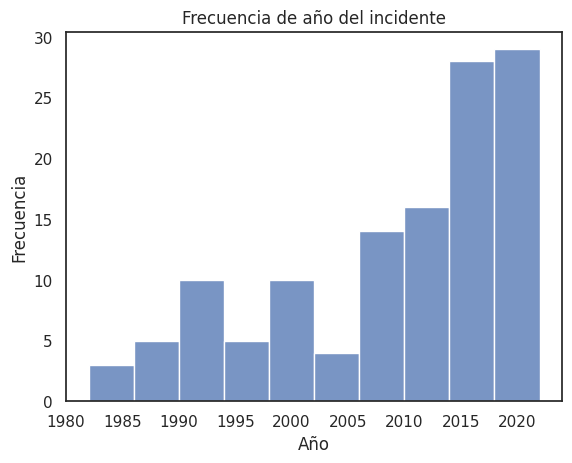

In [ ]:
# Histograma
sns.set(style="white")
ax = sns.histplot(df_ms['year'], bins=10)
ax.set(xlabel='Año', ylabel='Frecuencia', title= 'Frecuencia de año del incidente')

In [ ]:
skew(df_ms['year']) # asimetria

-0.839839327996871

In [ ]:
kurtosis(df_ms['year']) # curtosis

-0.5068095026441308

[Text(0.5, 0, 'Año'),
 Text(0, 0.5, 'Densidad'),
 Text(0.5, 1.0, 'Frecuencia de año del incidente')]

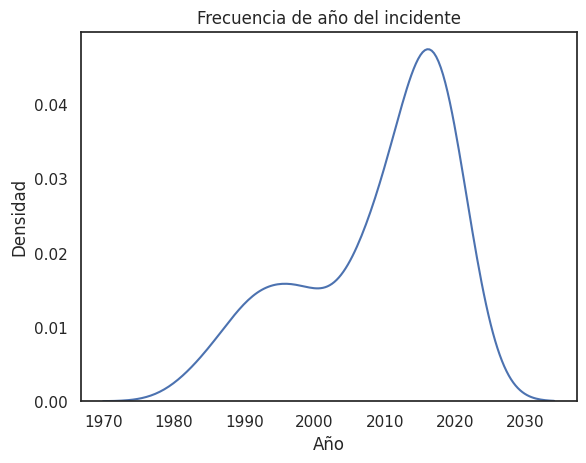

In [ ]:
ax = sns.kdeplot(df_ms['year'])
ax.set(xlabel='Año', ylabel='Densidad', title= 'Frecuencia de año del incidente')

### Variable 3: *número de victimas*

En relación con el número de víctimas, se identifican varios valores atípicos, destacando en particular un caso con 604 víctimas. Aunque este incidente es sin duda relevante y merece un análisis exhaustivo de manera individual, se tomó la decisión de omitirlo junto con otros valores atípicos para evitar posibles incongruencias en los resultados.

Además, la mayor frecuencia se obtuvo en el rango de 3-9 víctimas, con una distribución hacia la derecha (positiva) y escarpada (positiva).

[Text(0.5, 0, 'Número de víctimas')]

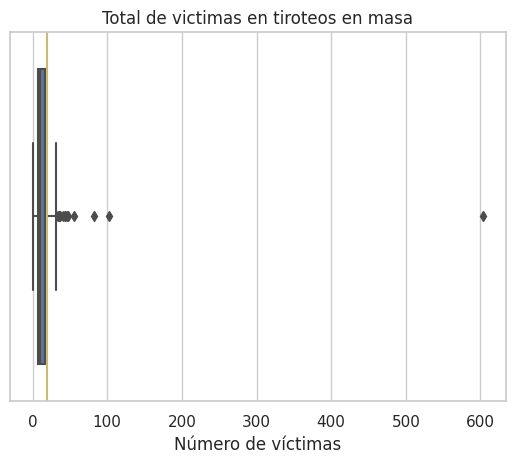

In [ ]:
# boxplot
sns.set(style="whitegrid")
ax = sns.boxplot(x=df_ms['total_victims'])
plt.axvline(df_ms['total_victims'].mean(), c='y')
plt.title('Total de victimas en tiroteos en masa')
ax.set(xlabel='Número de víctimas')

In [ ]:
df_ms.loc[df_ms['total_victims'] == 604]

,case,location,summary,total_victims,location.1,age_of_shooter,prior_signs_mental_health_issues,mental_health_details,race,gender,year
37,Las Vegas Strip massacre,"Las Vegas, Nevada","Stephen Craig Paddock, 64, fired a barrage of ...",604,Other,64,Unclear,Perpetrator's history unclear. In 1969 Paddock...,White,M,2017


In [ ]:
# Identificar valores atipicos con IQR
resumen_est = df_ms['total_victims'].describe()
iqr_edad = resumen_est['75%'] - resumen_est['25%']
score_iqr = 1.5 * iqr_edad
valor_min = resumen_est['25%'] - score_iqr
valor_min

-9.0

In [ ]:
valor_max = resumen_est['75%'] + score_iqr
valor_max

33.0

In [ ]:
df_ms['total_victims'].count()

124

In [ ]:
df_ms = df_ms.loc[df_ms['total_victims'] >= valor_min]


In [ ]:
df_ms = df_ms.loc[df_ms['total_victims'] <= valor_max]

In [ ]:
df_ms['total_victims'].count()

109

In [ ]:
# Tabla de frecuencias
segmentos = pd.cut(df_ms['total_victims'], 10)
df_ms['total_victims'].groupby(segmentos).count()

total_victims
(-0.032, 3.2]     8
(3.2, 6.4]       23
(6.4, 9.6]       26
(9.6, 12.8]      19
(12.8, 16.0]     15
(16.0, 19.2]      6
(19.2, 22.4]      5
(22.4, 25.6]      2
(25.6, 28.8]      2
(28.8, 32.0]      3
Name: total_victims, dtype: int64

[Text(0.5, 0, 'Número de víctimas'), Text(0, 0.5, 'Frecuencia')]

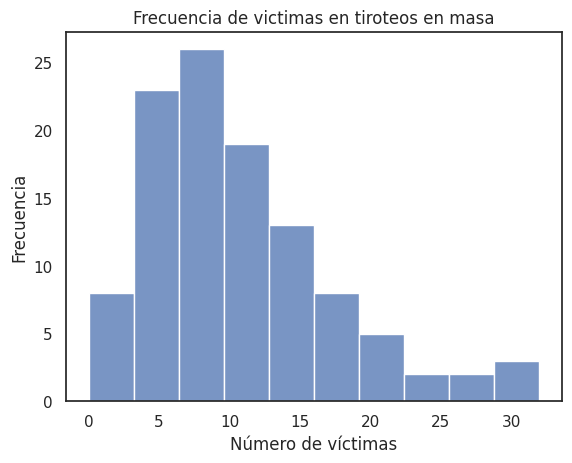

In [ ]:
# Histograma
sns.set(style="white")
ax = sns.histplot(df_ms['total_victims'], bins=10)
plt.title('Frecuencia de victimas en tiroteos en masa')
ax.set(xlabel='Número de víctimas', ylabel='Frecuencia')

In [ ]:
skew(df_ms['total_victims']) # asimetria

1.1414764587101833

In [ ]:
kurtosis(df_ms['total_victims']) # curtosis

0.9672171771306215

[Text(0.5, 0, 'Número de víctimas'), Text(0, 0.5, 'Densidad')]

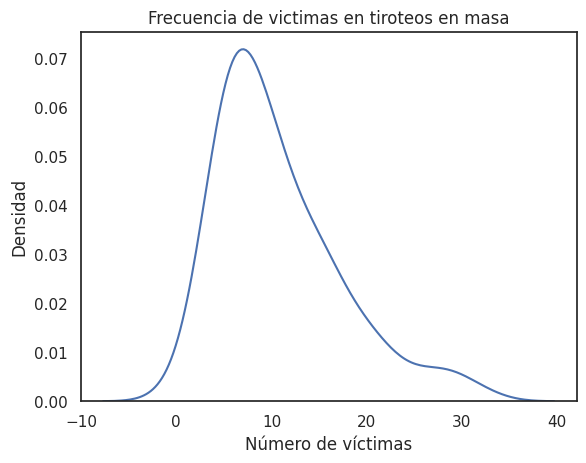

In [ ]:
ax = sns.kdeplot(df_ms['total_victims'])
plt.title('Frecuencia de victimas en tiroteos en masa')
ax.set(xlabel='Número de víctimas', ylabel='Densidad')

---

## 4. Exploración de Variables Categóricas y Análisis Multivariable

Se identificaron las variable categóricas con la finalidad de explorar la distribución de las variables.

In [ ]:
df_ms.columns

Index(['case', 'location', 'summary', 'total_victims', 'location.1',
       'age_of_shooter', 'prior_signs_mental_health_issues',
       'mental_health_details', 'race', 'gender', 'year'],
      dtype='object')

Con la finalidad de conocer la distribución de los datos de las variables categóricas se realizaron gráficas de barras y se calculó la moda.

### Variable 1: lugar del incidente

In [ ]:
df_ms['location.1'].unique()

array(['School', 'Workplace', 'Other', 'Religious', 'Airport', 'Military'],
      dtype=object)

In [ ]:
df_ms['location.1'].nunique()

6

In [ ]:
conteo_lugar = df_ms['location.1'].value_counts()
conteo_lugar

Workplace    43
Other        41
School       15
Religious     5
Military      4
Airport       1
Name: location.1, dtype: int64

Text(0.5, 1.0, 'Lugares en las que han ocurrido tiroteos')

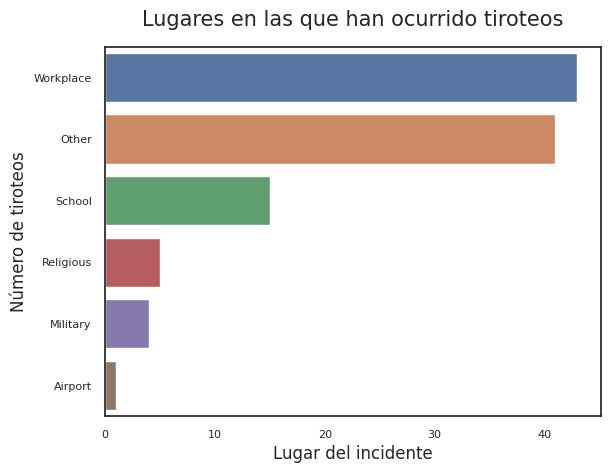

In [ ]:
lugar = sns.barplot(y=conteo_lugar.index, x=conteo_lugar, orient='h')
lugar.set(ylabel='Número de tiroteos', xlabel='Lugar del incidente')
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
lugar.set_title("Lugares en las que han ocurrido tiroteos", size=15, pad=15)

Moda. Valor típico que más se repite

In [ ]:
df_ms['location.1'].mode()

0    Workplace
Name: location.1, dtype: object

### Variable 2: síntomas de enfermedades mentales

In [ ]:
df_ms['prior_signs_mental_health_issues'].unique()

array(['Unclear', 'Yes', 'No'], dtype=object)

In [ ]:
df_ms['prior_signs_mental_health_issues'].nunique()

3

In [ ]:
conteo_sintomas = df_ms['prior_signs_mental_health_issues'].value_counts()
conteo_sintomas

Yes        55
Unclear    38
No         16
Name: prior_signs_mental_health_issues, dtype: int64

Text(0.5, 1.0, 'Incidencia de síntomas de enfermedades mentales')

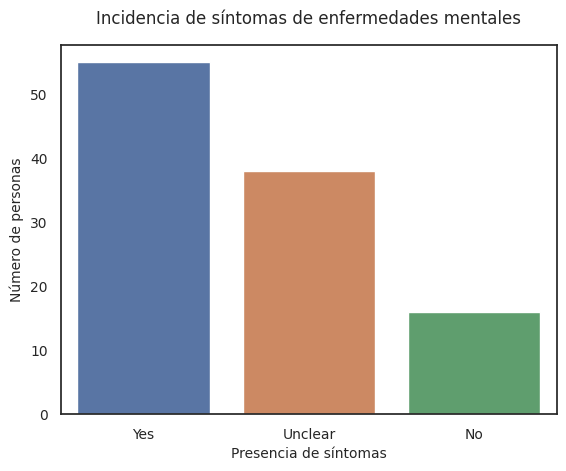

In [ ]:
sintomas = sns.barplot(x=conteo_sintomas.index, y=conteo_sintomas, orient='v')
plt.ylabel('Número de personas', fontsize=10)
plt.xlabel('Presencia de síntomas', fontsize=10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
sintomas.set_title("Incidencia de síntomas de enfermedades mentales", size=12, pad=15)


Moda. Valor típico que más se repite


In [ ]:
df_ms['prior_signs_mental_health_issues'].mode()

0    Yes
Name: prior_signs_mental_health_issues, dtype: object

### Variable 3: raza

In [ ]:
df_ms['race'].unique()

array(['Unclear', 'White', 'Black', 'Latino', 'Asian', 'Other',
       'Native American'], dtype=object)

In [ ]:
df_ms['race'].nunique()

7

In [ ]:
conteo_raza = df_ms['race'].value_counts()
conteo_raza

White              58
Black              20
Latino             10
Unclear             9
Asian               7
Native American     3
Other               2
Name: race, dtype: int64

Text(0.5, 1.0, 'Frecuencia de distintas razas en personas que han participado en tiroteos')

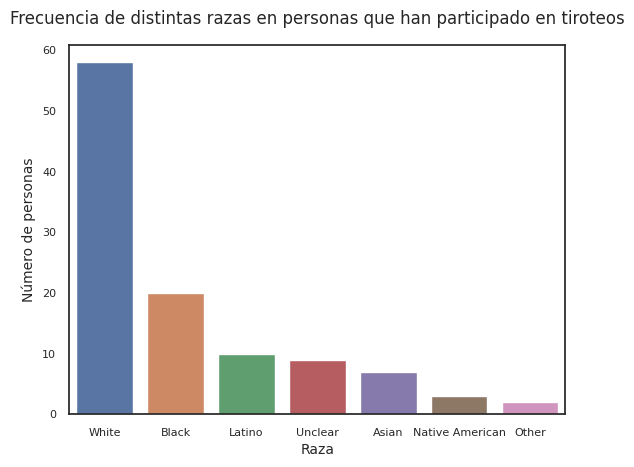

In [ ]:
raza = sns.barplot(x=conteo_raza.index, y=conteo_raza, orient='v')
plt.ylabel('Número de personas', fontsize=10)
plt.xlabel('Raza', fontsize=10)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
raza.set_title("Frecuencia de distintas razas en personas que han participado en tiroteos", size=12, pad=15)

Moda. Valor típico que más se repite


In [ ]:
df_ms['race'].mode()

0    White
Name: race, dtype: object

### Variable 4: género

In [ ]:
df_ms['gender'].unique()

array(['M', 'F'], dtype=object)

In [ ]:
df_ms['gender'].nunique()

2

In [ ]:
conteo_genero = df_ms['gender'].value_counts()
conteo_genero

M    106
F      3
Name: gender, dtype: int64

Text(0.5, 1.0, 'Frecuencia de cada género en personas que han participado en tiroteos')

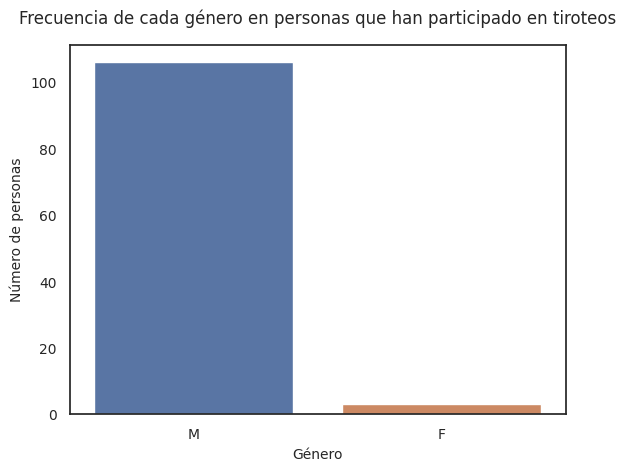

In [ ]:
genero = sns.barplot(x=conteo_genero.index, y=conteo_genero, orient='v')
plt.ylabel('Número de personas', fontsize=10)
plt.xlabel('Género', fontsize=10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
genero.set_title("Frecuencia de cada género en personas que han participado en tiroteos", size=12, pad=15)

Moda. valor que mas se repite

In [ ]:
df_ms['gender'].mode()

0    M
Name: gender, dtype: object

### Tabla de contingencia y gráficos múltiples. Variables categóricas.








Con la finalidad de ver las relaciones entre las variables categóricas se analizo la tabla de contigencia de las variables y se realizaron gráficos múltiples que nos brindan una visualización de las diferentes relaciones entre variables.

* **Raza y género.**
Al relacionar estas variables algo que es importante destacar que el resultado que nos arroja es que la mayoría de tiroteos fueron hechos por hombres de raza blanca.

In [ ]:
crosstab = pd.crosstab(df_ms['gender'], df_ms['race'])
crosstab

race,Asian,Black,Latino,Native American,Other,Unclear,White
gender,,,,,,,
F,0,1,0,1,0,0,1
M,7,19,10,2,2,9,57


<Axes: xlabel='race', ylabel='M'>

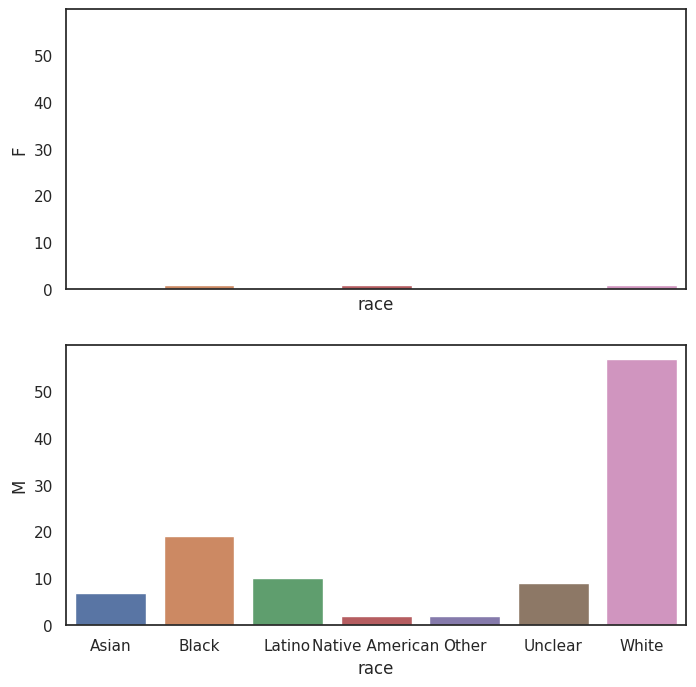

In [ ]:
fig, axes = plt.subplots(2,1, figsize = (8,8), sharex=True, sharey=True) # se agrego tamaño de figura y que se compartan los ejes 'x' y 'y'

sns.barplot(x=crosstab.columns, y=crosstab.loc['F'], ax=axes[0])
sns.barplot(x=crosstab.columns, y=crosstab.loc['M'], ax=axes[1])

* **Localización y género.**
 Al relacionar estas variables algo que es importante destacar que el resultado que nos arroja es que la mayoría de tiroteos complementando la información anterior fueron en lugares de trabajo.



In [ ]:
crosstab = pd.crosstab(df_ms['gender'], df_ms['location.1'])
crosstab

location.1,Airport,Military,Other,Religious,School,Workplace
gender,,,,,,
F,0,0,1,0,0,2
M,1,4,40,5,15,41


<Axes: xlabel='location.1', ylabel='M'>

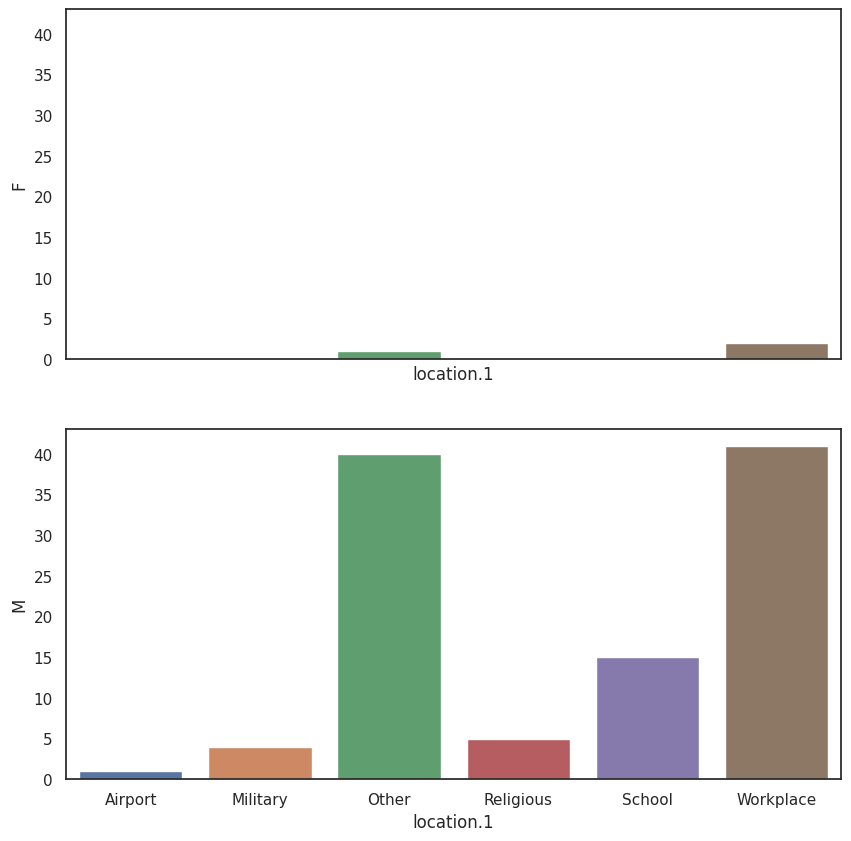

In [ ]:
fig, axes = plt.subplots(2,1, figsize = (10,10), sharex=True, sharey=True)

sns.barplot(x=crosstab.columns, y=crosstab.loc['F'], ax=axes[0])
sns.barplot(x=crosstab.columns, y=crosstab.loc['M'], ax=axes[1])

* **Raza y síntomas de enfermedad mental.**
 Al relacionar estas variables algo que es importante destacar que el resultado que nos arroja es que la mayoría de tiroteos fueron hechos por personas con signos de enfermedad mental de raza blanca.










In [ ]:
crosstab = pd.crosstab(df_ms['prior_signs_mental_health_issues'], df_ms['race'])
crosstab

race,Asian,Black,Latino,Native American,Other,Unclear,White
prior_signs_mental_health_issues,,,,,,,
No,0,6,1,0,0,1,8
Unclear,1,8,4,2,2,5,16
Yes,6,6,5,1,0,3,34


<Axes: xlabel='race', ylabel='Yes'>

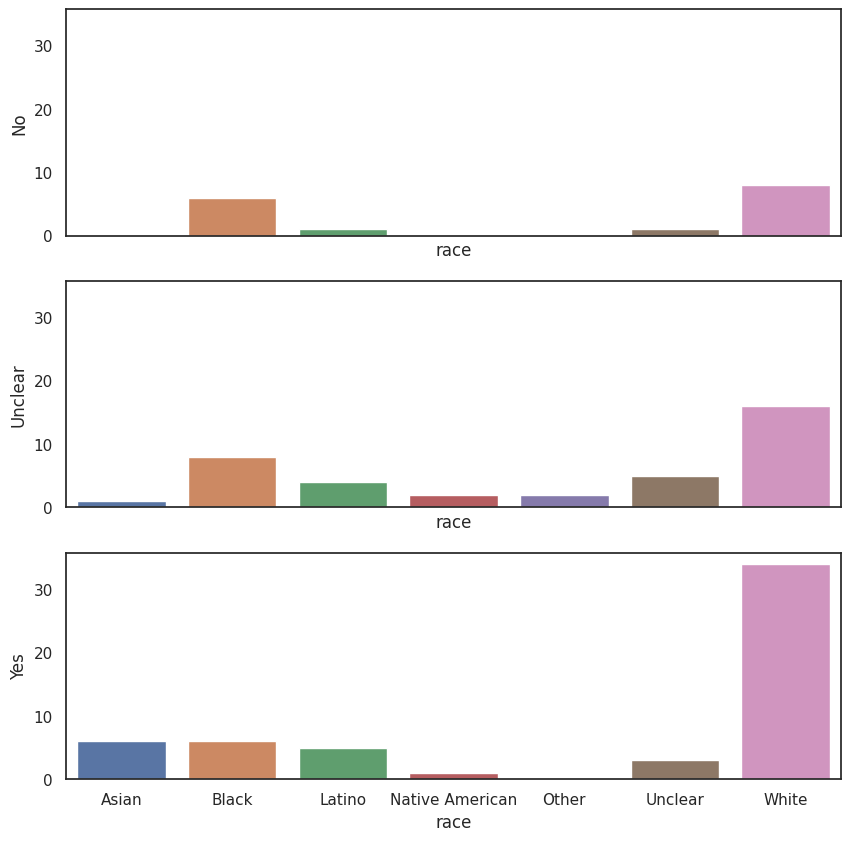

In [ ]:
fig, axes = plt.subplots(3,1, figsize = (10,10), sharex=True, sharey=True)

sns.barplot(x=crosstab.columns, y=crosstab.loc['No'], ax=axes[0])
sns.barplot(x=crosstab.columns, y=crosstab.loc['Unclear'], ax=axes[1])
sns.barplot(x=crosstab.columns, y=crosstab.loc['Yes'], ax=axes[2])

* **Localización y síntomas de enfermedad mental.**
Al relacionar estas variables algo que es importante destacar que el resultado que nos arroja es que la mayoría de tiroteos fueron hechos por personas con signos de enfermedad mental en el trabajo.




In [ ]:
crosstab = pd.crosstab(df_ms['prior_signs_mental_health_issues'], df_ms['location.1'])
crosstab

location.1,Airport,Military,Other,Religious,School,Workplace
prior_signs_mental_health_issues,,,,,,
No,0,0,7,0,3,6
Unclear,0,2,13,2,6,15
Yes,1,2,21,3,6,22


<Axes: xlabel='location.1', ylabel='Yes'>

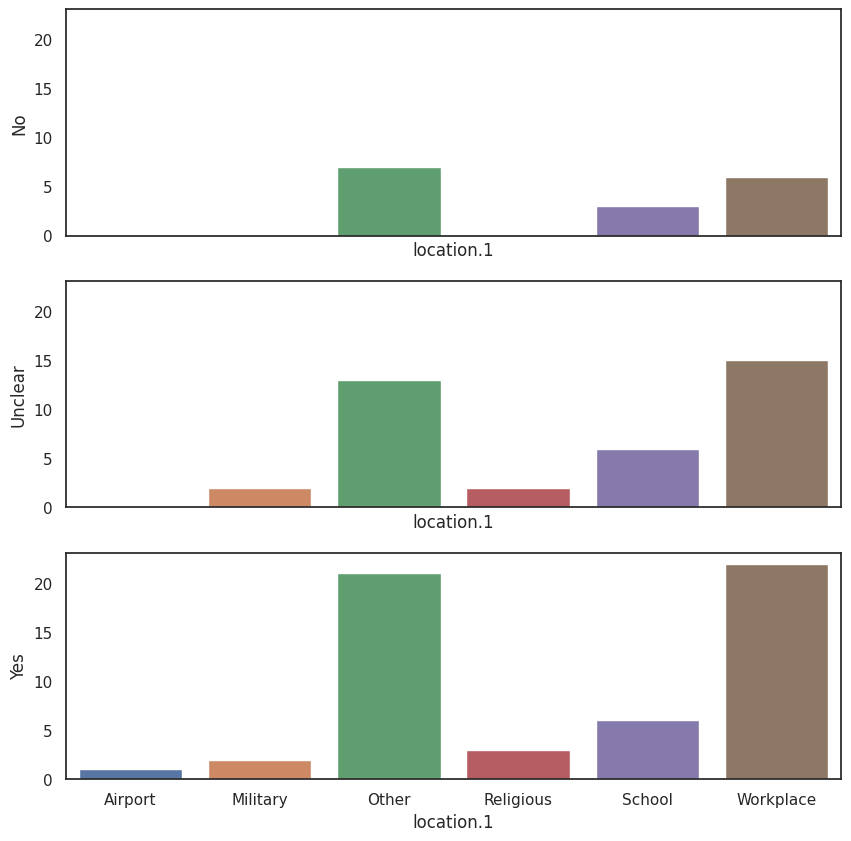

In [ ]:
fig, axes = plt.subplots(3,1, figsize = (10,10), sharex=True, sharey=True)

sns.barplot(x=crosstab.columns, y=crosstab.loc['No'], ax=axes[0])
sns.barplot(x=crosstab.columns, y=crosstab.loc['Unclear'], ax=axes[1])
sns.barplot(x=crosstab.columns, y=crosstab.loc['Yes'], ax=axes[2])

### Boxplot y violonplots.Relación variables númericas y categorícas





Con la finalidad de ver las relaciones entre variables categóricas y númericas se visualizo su relación con gráficos boxplot y violinplot para identificar la dispersión de los datos y ver los valores átipicos.

* **Relación de raza y edad.**
El boxplot nos muestra que los valores de la raza blanca, asiáticos, otros y desconocido tienen valores atípicos que nos puede decir que esas edades pasan por mucho los valores típicos que se puede ver que son mayores de 40 años. Otro dato interesante que arroja es que los nativos americanos son los que la mediana es menor a 20 años que nos indica que son demasiado jóvenes los que hacen los tiroteos y se presenta una mayor dispersión de datos en la raza blanca. La mediana de las diferentes razas excepto de los nativos esta entre los 20 y 40 años.

(array([0, 1, 2, 3, 4, 5, 6]),
 [Text(0, 0, 'Unclear'),
  Text(1, 0, 'White'),
  Text(2, 0, 'Black'),
  Text(3, 0, 'Latino'),
  Text(4, 0, 'Asian'),
  Text(5, 0, 'Other'),
  Text(6, 0, 'Native American')])

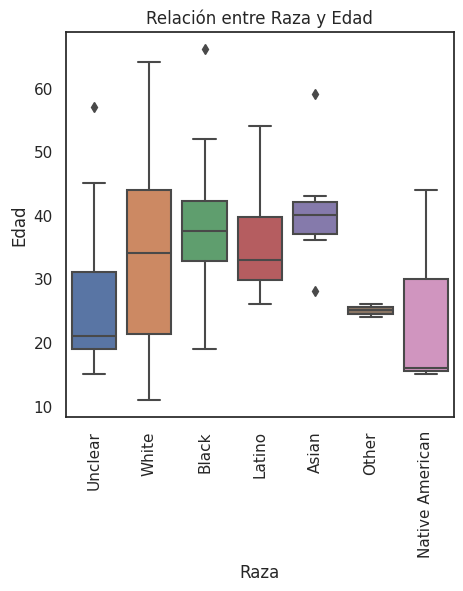

In [ ]:
plt.figure(figsize=(5, 5))
sns.boxplot(data=df_ms, x='race', y='age_of_shooter');
plt.title('Relación entre Raza y Edad')
plt.xlabel('Raza')
plt.ylabel('Edad')
plt.xticks(rotation=90)

(array([0, 1, 2, 3, 4, 5, 6]),
 [Text(0, 0, 'Unclear'),
  Text(1, 0, 'White'),
  Text(2, 0, 'Black'),
  Text(3, 0, 'Latino'),
  Text(4, 0, 'Asian'),
  Text(5, 0, 'Other'),
  Text(6, 0, 'Native American')])

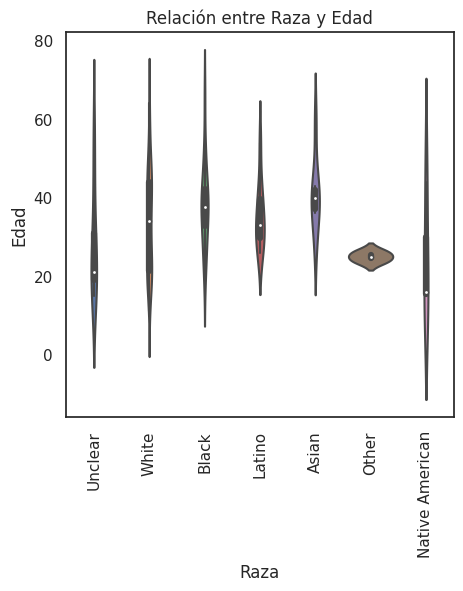

In [ ]:
plt.figure(figsize=(5, 5))
sns.violinplot(data=df_ms, x='race', y='age_of_shooter');
plt.title('Relación entre Raza y Edad')
plt.xlabel('Raza')
plt.ylabel('Edad')
plt.xticks(rotation=90)

* **Relación de variables año y localización**.
Algo importante a destacar es que en el aeropuerto es donde se han presentado el menor número de tiroteos en todos los años, por lo que podriamos decir que de los lugares evaluados en donde se presenta una mayor seguridad. En otros y en el escuadron militar se presentan datos atípicos que se presentan antes de los años 1995. Se puede ver que las medianas de los tiroteos en los diferentes lugares se encuentran desde el año 2007 al 2016.

(array([0, 1, 2, 3, 4, 5]),
 [Text(0, 0, 'School'),
  Text(1, 0, 'Workplace'),
  Text(2, 0, 'Other'),
  Text(3, 0, 'Religious'),
  Text(4, 0, 'Airport'),
  Text(5, 0, 'Military')])

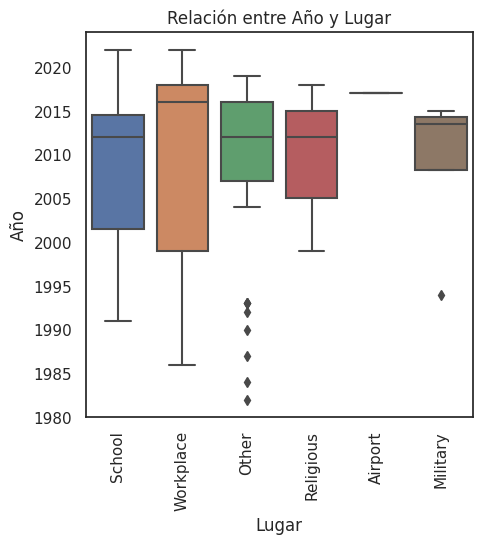

In [ ]:
plt.figure(figsize=(5, 5))
sns.boxplot(data=df_ms, x='location.1', y='year');
plt.title('Relación entre Año y Lugar')
plt.xlabel('Lugar')
plt.ylabel('Año')
plt.xticks(rotation=90)

(array([0, 1, 2, 3, 4, 5]),
 [Text(0, 0, 'School'),
  Text(1, 0, 'Workplace'),
  Text(2, 0, 'Other'),
  Text(3, 0, 'Religious'),
  Text(4, 0, 'Airport'),
  Text(5, 0, 'Military')])

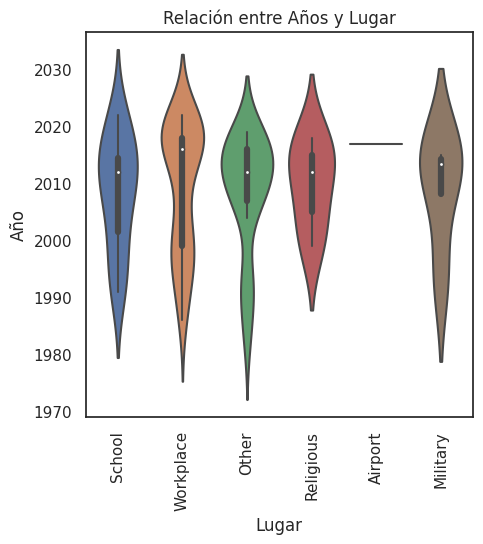

In [ ]:
plt.figure(figsize=(5, 5))
sns.violinplot(data=df_ms, x='location.1', y='year');
plt.title('Relación entre Años y Lugar')
plt.xlabel('Lugar')
plt.ylabel('Año')
plt.xticks(rotation=90)

* **Relación de variables género y edad**
Por los resultados podemos ver que se presentan más casos de hombres que provocan los tiroteos y que por las dispersión de los datos van desde los 10 años hasta los 65 años. Y la mediana de los hombres es de 35 años mientras que de las mujeres es de 45 años.

(array([0, 1]), [Text(0, 0, 'M'), Text(1, 0, 'F')])

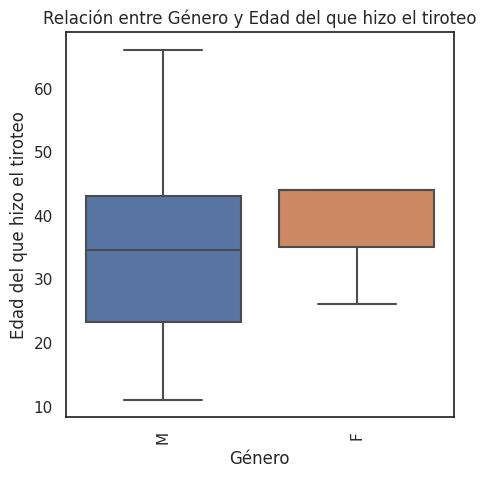

In [ ]:
plt.figure(figsize=(5, 5))
sns.boxplot(data=df_ms, x='gender', y='age_of_shooter');
plt.title('Relación entre Género y Edad del que hizo el tiroteo')
plt.xlabel('Género')
plt.ylabel('Edad del que hizo el tiroteo')
plt.xticks(rotation=90)

(array([0, 1]), [Text(0, 0, 'M'), Text(1, 0, 'F')])

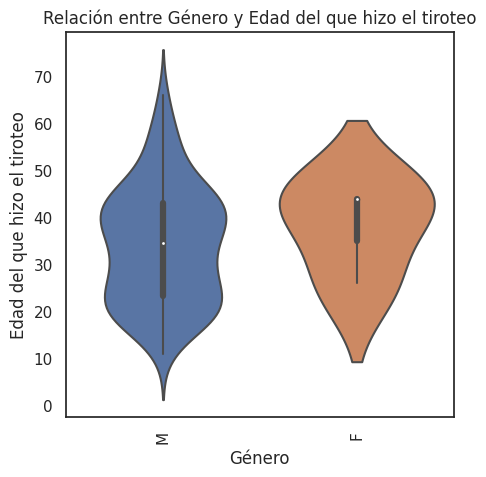

In [ ]:
plt.figure(figsize=(5, 5))
sns.violinplot(data=df_ms, x='gender', y='age_of_shooter');
plt.title('Relación entre Género y Edad del que hizo el tiroteo')
plt.xlabel('Género')
plt.ylabel('Edad del que hizo el tiroteo')
plt.xticks(rotation=90)

## 5. Correlaciones y Regresión Lineal Simple
Se identificaron las variables númericas y se genero una matriz de correlaciones y un pairplot que nos permiten visualizar de una mejor manera las relaciones entre las variables.

In [ ]:
df_sin_nans = df_ms.dropna()
df_sin_nans.corr()

<ipython-input-504-5daea2f1a131>:2: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



,total_victims,age_of_shooter,year
total_victims,1.000000,-0.115314,-0.236986
age_of_shooter,-0.115314,1.000000,-0.184934
year,-0.236986,-0.184934,1.000000


<ipython-input-505-3bf057f9eabb>:2: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



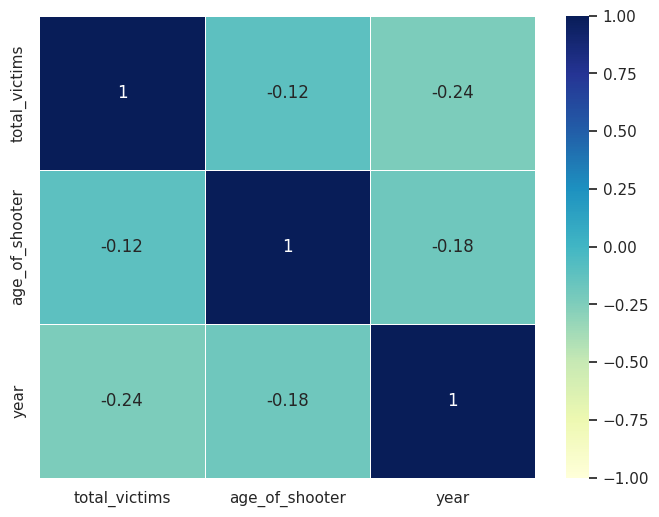

In [ ]:
plt.figure(figsize=(8, 6))
ax = sns.heatmap(df_sin_nans.corr(), vmin=-1, vmax=1, annot=True, cmap="YlGnBu", linewidths=.5);


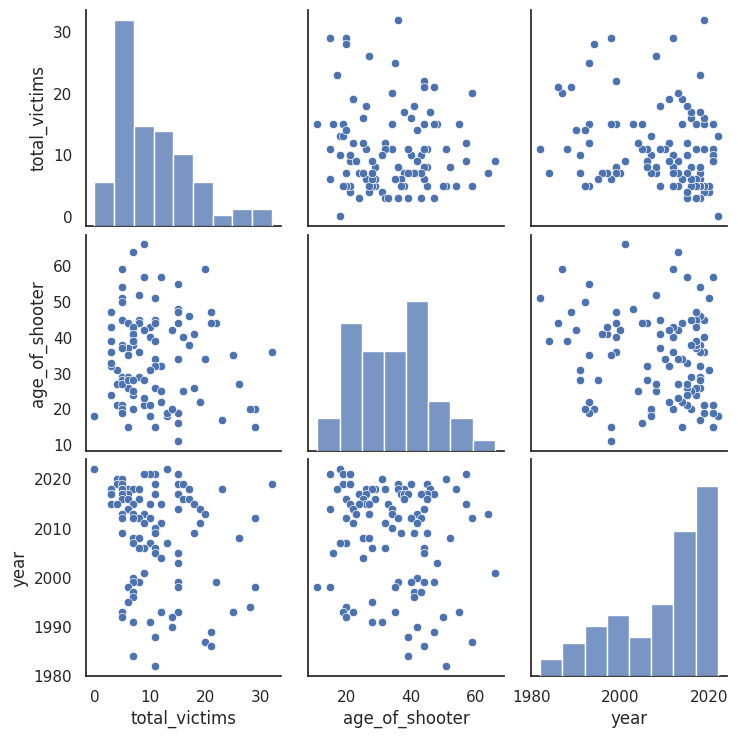

In [ ]:
sns.pairplot(df_ms);

Se puede destacar que la relación de la variable de total de víctimas tiene una correlación positiva con las otras dos variables númericas que nos indica que si una de ellas aumenta las otras támbien pero por el valor tan pequeño se considera que su relación no es muy fuerte. Sin embargo, la edad del tirador tiene una correlación negativa con el año que nos indica que si una de ellas aumenta la otra disminuye.


### Gráfica de dispersión.




Se realizaron gráficas de dispersión, al ver los datos atípicos se decidira si se quitan o se dejan para mejorar el valor de la correlación entre variables númericas.

**Relación variables total de víctimas y edad del tirador.**

<Axes: xlabel='total_victims', ylabel='age_of_shooter'>

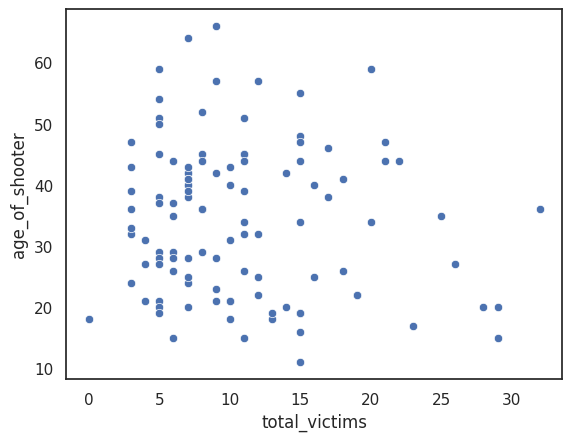

In [ ]:
sns.scatterplot(x=df_ms['total_victims'], y=df_ms['age_of_shooter'])

In [ ]:
df_ms['total_victims'].corr(df_ms['age_of_shooter'])

-0.11531355568268196

<Axes: xlabel='total_victims', ylabel='age_of_shooter'>

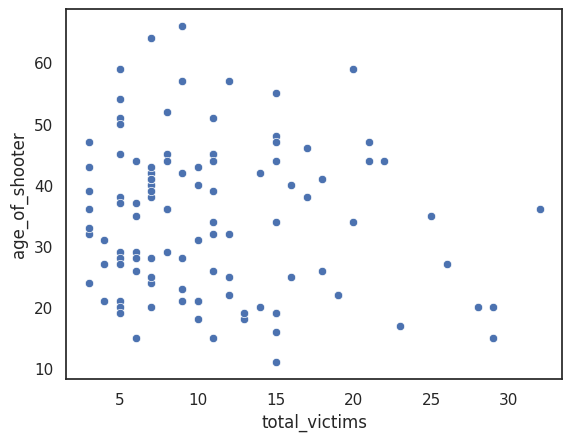

In [ ]:
df_no_zeros = df_ms[df_ms['total_victims'] > 0]
sns.scatterplot(x=df_no_zeros['total_victims'], y=df_no_zeros['age_of_shooter'])

In [ ]:
df_no_zeros['total_victims'].corr(df_ms['age_of_shooter'])

-0.13856309539466408

**Relación variables total de víctimas y años de los sucesos.**

<Axes: xlabel='total_victims', ylabel='year'>

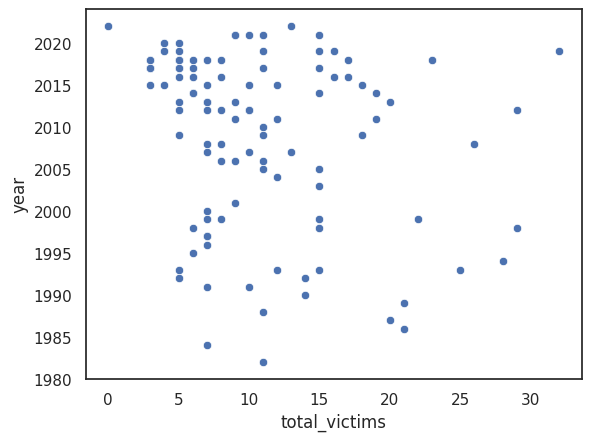

In [ ]:
sns.scatterplot(x=df_ms['total_victims'], y=df_ms['year'])

In [ ]:
df_ms['total_victims'].corr(df_ms['year'])

-0.23698646140408097

<Axes: xlabel='total_victims', ylabel='year'>

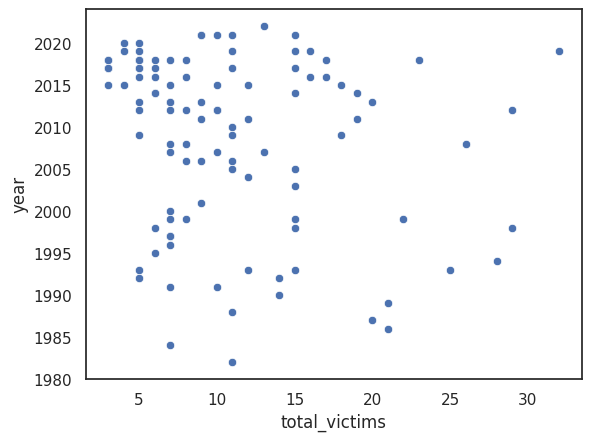

In [ ]:
df_no_zeros = df_ms[df_ms['total_victims'] > 0]
sns.scatterplot(x=df_no_zeros['total_victims'], y=df_no_zeros['year'])

In [ ]:
df_no_zeros['total_victims'].corr(df_ms['year'])

-0.2220249264387948

Como se puede ver la corelación entre las variables es muy baja, al igual podemos destacar que hay un valor átipico en 600 víctimas pero no se eliminó porque primero disminuye la correlación y además es un dato que se presentó y es representativo.

**Relación variables edad del tirador y años de los sucesos.**

<Axes: xlabel='age_of_shooter', ylabel='year'>

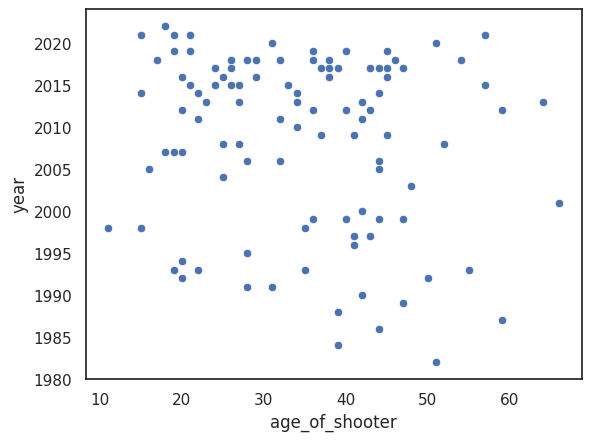

In [ ]:
sns.scatterplot(x=df_ms['age_of_shooter'], y=df_ms['year'])

In [ ]:
df_ms['year'].corr(df_ms['age_of_shooter'])

-0.1849344047357441

<Axes: xlabel='age_of_shooter', ylabel='year'>

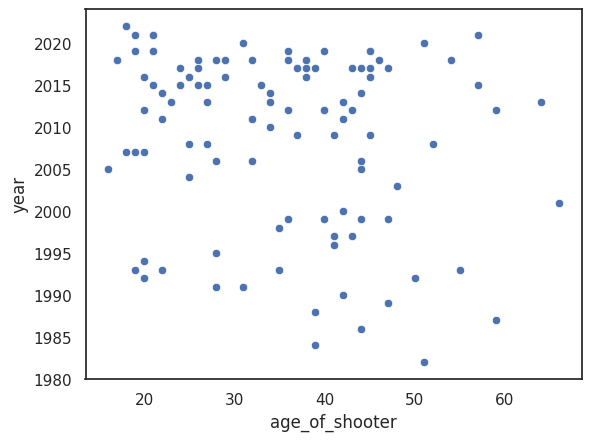

In [ ]:
df_no_zeros = df_ms[df_ms['age_of_shooter'] > 15]
sns.scatterplot(x=df_no_zeros['age_of_shooter'], y=df_no_zeros['year'])

In [ ]:
df_no_zeros['age_of_shooter'].corr(df_ms['year'])

-0.20912924494231075

Por la dispersión de los datos al disminuir el valor de 0 o valores atípicos se da una correlación menor por lo que solo se decidio quitar los valores de 0.

### **Regresión lineal**.

Se realizo un modelo de regresión lineal de la variable de incidente y edad del disparador para entender la dispersión de los datos y la relación entre las variables.

Variables analizadas: año de incidente y edad del disparador.

In [ ]:
lr = LinearRegression()

lr.fit(df_ms['age_of_shooter'].to_frame(), df_ms['year'])

LinearRegression()

In [ ]:
y_predict = lr.predict(df_ms['age_of_shooter'].to_frame())

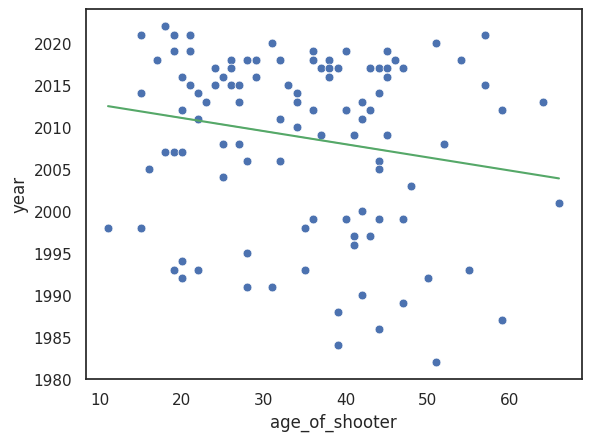

In [ ]:
sns.scatterplot(x=df_ms['age_of_shooter'], y=df_ms['year'], s=40);
sns.lineplot(x=df_ms['age_of_shooter'], y=y_predict, color='g');

In [ ]:
lr.score(df_ms['age_of_shooter'].to_frame(), df_ms['year'])

0.0342007340549626

En este caso podemos decir que la variable de la edad del tirador explica el 0.02% de la variabilidad de la variable de los años de los sucesos.

## 6. Distribuciones muestrales y técnicas de evaluación de modelos

Con la finalidad de conocer a mas profundidad los datos de las variables categóricas se exploró  la distribución, asimetría, curtosis, error estándar y el intervalo de confianza con la técnica de bootstrap

###Variable año

In [ ]:
año = df_ms['year']

means = []

for i in range(100_000):
    sample = año.sample(n=50, replace=True)
    means.append(sample.mean())

serie_means = pd.Series(means)

In [ ]:
sns.distplot(serie_means, kde=False, norm_hist=False);
plt.xlabel('Años')
plt.ylabel('Personas')

In [ ]:
serie_means.skew()

La medida de sesgo nos indica que la cola de la distribución se inclina hacia la izquierda.

In [ ]:
serie_means.kurtosis()

El tipo de kurtosis es platicúrtica que nos indica un pico mas aplanado que el de una distribución normal.

In [ ]:
print(f'Error estandar: {serie_means.std()}')

In [ ]:
print(f'Valor mínimo: {serie_means.min()}')
print(f'Valor máximo: {serie_means.max()}')
print(f'Rango: {serie_means.max() - serie_means.min()}')

In [ ]:
sns.boxplot(serie_means);

In [ ]:
limite_inferior = serie_means.quantile(0.025)
limite_superior = serie_means.quantile(0.975)

In [ ]:
print(f'Intervalo de 95% confianza de la media: {limite_inferior} < {año.mean()} < {limite_superior}')

In [ ]:
mean_of_intervals = ((año.mean() - limite_inferior) + (limite_superior - año.mean())) / 2

print(f'Intervalo de 95% confianza de la media: {año.mean()} +/- {mean_of_intervals}')

In [ ]:
sns.distplot(serie_means, kde=False, norm_hist=False)
plt.axvline(limite_inferior)
plt.axvline(limite_superior);
plt.xlabel('Años')
plt.ylabel('Personas')

### Variable edad del tirador.

In [ ]:
edad = pd.to_numeric(df_ms["age_of_shooter"], errors="coerce")

means = []

for i in range(100_000):
    sample = edad.sample(n=50, replace=True)
    means.append(sample.mean())

serie_means = pd.Series(means)

<ipython-input-535-b096aeaf5ed7>:1: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




Text(0, 0.5, 'Personas')

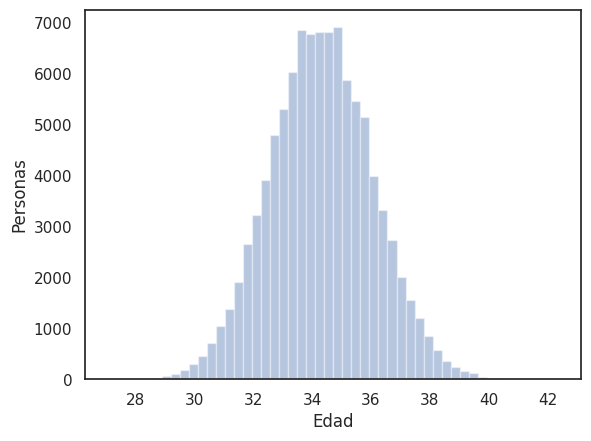

In [ ]:
sns.distplot(serie_means, kde=False, norm_hist=False);
plt.xlabel('Edad')
plt.ylabel('Personas')


In [ ]:
serie_means.skew()

0.048071546309517224

Los valores obtenidos del teorema del límite central ya que se acerca a 0 podemos decir que se acerca a la normalidad

In [ ]:
serie_means.kurtosis()

-0.018496452975286903

El tipo de kurtosis es platicúrtica que nos indica un pico mas aplanado que el de una distribución normal

In [ ]:
print(f'Error estandar: {serie_means.std()}')

Error estandar: 1.7389886731854851


El valor del error estandar esta bien porque nos indica que los datos se separan por 1.75 unidades de la media.

In [ ]:
print(f'Valor mínimo: {serie_means.min()}')
print(f'Valor máximo: {serie_means.max()}')
print(f'Rango: {serie_means.max() - serie_means.min()}')

Valor mínimo: 27.06
Valor máximo: 42.38
Rango: 15.320000000000004


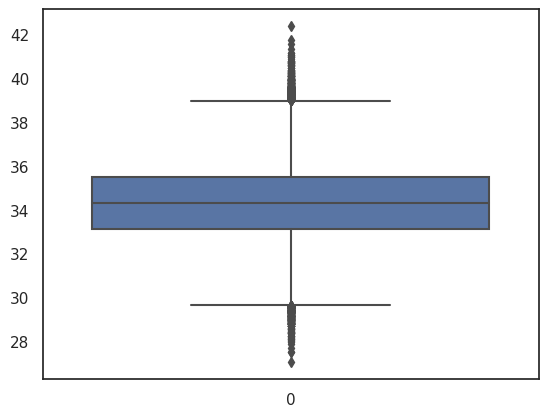

In [ ]:
sns.boxplot(serie_means);

In [ ]:
limite_inferior = serie_means.quantile(0.025)
limite_superior = serie_means.quantile(0.975)

In [ ]:
print(f'Intervalo de 95% confianza de la media: {limite_inferior} < {edad.mean()} < {limite_superior}')

Intervalo de 95% confianza de la media: 30.94 < 34.31192660550459 < 37.76


<ipython-input-543-5edef4ad0314>:1: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




Text(0, 0.5, 'Personas')

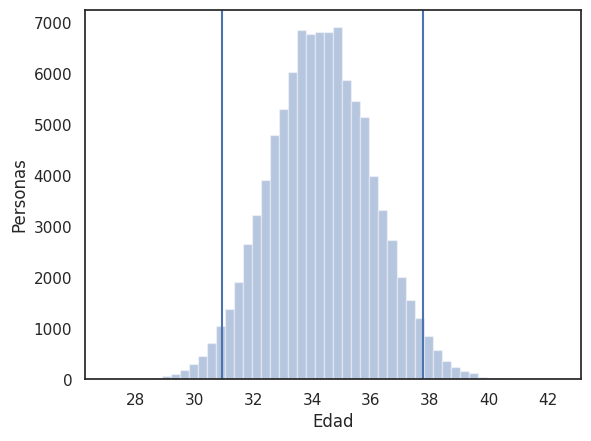

In [ ]:
sns.distplot(serie_means, kde=False, norm_hist=False)
plt.axvline(limite_inferior)
plt.axvline(limite_superior);
plt.xlabel('Edad')
plt.ylabel('Personas')

In [ ]:
edad = pd.to_numeric(df_ms["age_of_shooter"], errors="coerce")

means = []

for i in range(100_000):
    sample = edad.sample(n=50, replace=True)
    means.append(sample.mean())

serie_means = pd.Series(means)

In [ ]:
sns.distplot(serie_means, kde=False, norm_hist=False);
plt.xlabel('Edad')
plt.ylabel('Personas')


In [ ]:
serie_means.skew()

Los valores obtenidos del teorema del límite central ya que se acerca a 0 podemos decir que se acerca a la normalidad

In [ ]:
serie_means.kurtosis()

El tipo de kurtosis es platicúrtica que nos indica un pico mas aplanado que el de una distribución normal

In [ ]:
print(f'Error estandar: {serie_means.std()}')

El valor del error estandar esta bien porque nos indica que los datos se separan por 1.75 unidades de la media.

In [ ]:
print(f'Valor mínimo: {serie_means.min()}')
print(f'Valor máximo: {serie_means.max()}')
print(f'Rango: {serie_means.max() - serie_means.min()}')

In [ ]:
sns.boxplot(serie_means);

In [ ]:
limite_inferior = serie_means.quantile(0.025)
limite_superior = serie_means.quantile(0.975)

In [ ]:
print(f'Intervalo de 95% confianza de la media: {limite_inferior} < {edad.mean()} < {limite_superior}')

In [ ]:
sns.distplot(serie_means, kde=False, norm_hist=False)
plt.axvline(limite_inferior)
plt.axvline(limite_superior);

### Variable total de víctimas.





In [ ]:
victimas = pd.to_numeric(df_ms["total_victims"], errors="coerce")

means = []

for i in range(100_000):
    sample = victimas.sample(n=50, replace=True)
    means.append(sample.mean())

serie_means = pd.Series(means)

In [ ]:
sns.distplot(serie_means, kde=False, norm_hist=False);
plt.xlabel('Victimas')
plt.ylabel('Muestra')

In [ ]:
serie_means.skew()

Los valores obtenidos del teorema del límite central ya que no se acercan a 0 podemos decir que no se acerca a la normalidad

In [ ]:
serie_means.kurtosis()

El tipo de kurtosis es de tipo leptocúrtica que nos indica un pico más alto que la distribución normal.

In [ ]:
print(f'Error estandar: {serie_means.std()}')

El valor del error estandar  nos indica que los datos se separan por 7.6 unidades de la media.

In [ ]:
print(f'Valor mínimo: {serie_means.min()}')
print(f'Valor máximo: {serie_means.max()}')
print(f'Rango: {serie_means.max() - serie_means.min()}')

In [ ]:
sns.boxplot(serie_means);

In [ ]:
limite_inferior = serie_means.quantile(0.025)
limite_superior = serie_means.quantile(0.975)

In [ ]:
print(f'Intervalo de 95% confianza de la media: {limite_inferior} < {edad.mean()} < {limite_superior}')

In [ ]:
sns.distplot(serie_means, kde=False, norm_hist=False)
plt.axvline(limite_inferior)
plt.axvline(limite_superior);
plt.xlabel('Victimas')
plt.ylabel('Muestra')


### Modelos de Regresión Lineal Múltiple

Se realizo un modelo de regresión lineal múltiple para conocer a mas profundidad la relación entre una variable dependiente y otras independientes.

In [ ]:
df_ms.isna().sum()

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X = df_ms[['total_victims', 'year']]
y = df_ms['age_of_shooter']

In [ ]:
X_training, X_test, y_training, y_test = train_test_split(X, y, test_size=0.3, shuffle=True)


In [ ]:
lr = LinearRegression()
lr.fit(X_training, y_training)

In [ ]:
lr.score(X_test, y_test)

Este resultado se puede deber a la falta de datos.

In [ ]:
lr_2 = LinearRegression()
lr_2.fit(X, y)

In [ ]:
lr_2.score(X, y)

Este valor nos indica que se tuvo un sobreajuste y que con datos conocidos se harán predicciones pero con datos nuevos no podra analizarlos.

###Validación cruzada

In [ ]:
lr = LinearRegression()
scores = cross_validate(lr, X, y, scoring='r2')
scores

In [ ]:
print(f'Score del modelo: {scores["test_score"].mean():.3f} +/- {scores["test_score"].std():.3f}')

Obteniendo los resultados el score promedio al obtener un valor negativo indica un buen rendimiento en algunas métricas. Y la desviación estándar sugiere que existe la variabilidad en el rendimiento del modelo.

## 7. Visualización de Datos Avanzada

Para poder comprender mejor la relación de las variables de interés, se llevaron a cabo técnicas de visualización de datos avanzada.

### Treemaps

In [ ]:
df_ms.columns

Index(['case', 'location', 'summary', 'total_victims', 'location.1',
       'age_of_shooter', 'prior_signs_mental_health_issues',
       'mental_health_details', 'race', 'gender', 'year'],
      dtype='object')

* Locación y sintomas. Se observó que en los incidentes en el trabajo y lugares religiosos predominan los tiradores que **si** presentan sintomas de enfermedades mentales, mientras que en escuelas y lugares militares, hay mayor cantidad de personas de las cuales se desconoce su salud mental.

In [ ]:
# Treemap
df_grouped = df_ms.groupby('case')[['location.1', 'prior_signs_mental_health_issues']].max()
df_grouped.head()

,location.1,prior_signs_mental_health_issues
case,,
101 California Street shootings,Other,No
Accent Signage Systems shooting,Workplace,Yes
Air Force base shooting,Military,Yes
Alturas tribal shooting,Other,Unclear
Amish school shooting,School,No


In [ ]:
df_grouped['count'] = 1

In [ ]:
import plotly.express as px

In [ ]:
fig = px.treemap(df_grouped, path=['location.1', 'prior_signs_mental_health_issues'], values='count')
fig.show()

* Locación y edad. Existe una gran variabilidad de edades con respecto a los lugares de los incidentes.

  En el trabajo hay mayor frecuencia de personas entre 20 y 40 años. Por otro lado, en la escuela predomian los tiradores de 15-20 años.

In [ ]:
df_grouped = df_ms.groupby('case')[['location.1', 'age_of_shooter']].max()
df_grouped.head()

,location.1,age_of_shooter
case,,
101 California Street shootings,Other,55
Accent Signage Systems shooting,Workplace,36
Air Force base shooting,Military,20
Alturas tribal shooting,Other,44
Amish school shooting,School,32


In [ ]:
df_grouped['count'] = 1

In [ ]:
fig = px.treemap(df_grouped, path=['location.1', 'age_of_shooter'], values='count')
fig.show()

* Locación y año. Según los resultados, el año en que hubo más tiroteos en el trabajo fue en 2018 (6), en escuelas fue en 2014 (2) y en otro tipo de lugares en 2013 (4).

In [ ]:
df_grouped = df_ms.groupby('case')[['location.1', 'year']].max()
df_grouped.head()

,location.1,year
case,,
101 California Street shootings,Other,1993
Accent Signage Systems shooting,Workplace,2012
Air Force base shooting,Military,1994
Alturas tribal shooting,Other,2014
Amish school shooting,School,2006


In [ ]:
df_grouped['count'] = 1

In [ ]:
fig = px.treemap(df_grouped, path=['location.1', 'year'], values='count')
fig.show()

* Raza y síntomas. En personas blancas y latinas predomina la presencia de sintomas de enfermedades mentales, mientras que en personas de raza negra predominan los casos en los que desconoce la salud mental del individuo.

In [ ]:
df_grouped = df_ms.groupby('case')[['race', 'prior_signs_mental_health_issues']].max()
df_grouped.head()

,race,prior_signs_mental_health_issues
case,,
101 California Street shootings,White,No
Accent Signage Systems shooting,White,Yes
Air Force base shooting,White,Yes
Alturas tribal shooting,Native American,Unclear
Amish school shooting,White,No


In [ ]:
df_grouped['count'] = 1

In [ ]:
fig = px.treemap(df_grouped, path=['race', 'prior_signs_mental_health_issues'], values='count')
fig.show()

### Scatterplots

* Año del incidente, edad y sintomas. Debido a la baja correlación que existe entre las variables, se tomó la decisión de hacer un solo grafico de dispersió multiple.

  Se pudo observar que en años más recientes hay una mayor cantidad de casos en las que se desconoce la salud mental del individuo y que este aumento es independiente de la edad.

<Axes: xlabel='year', ylabel='age_of_shooter'>

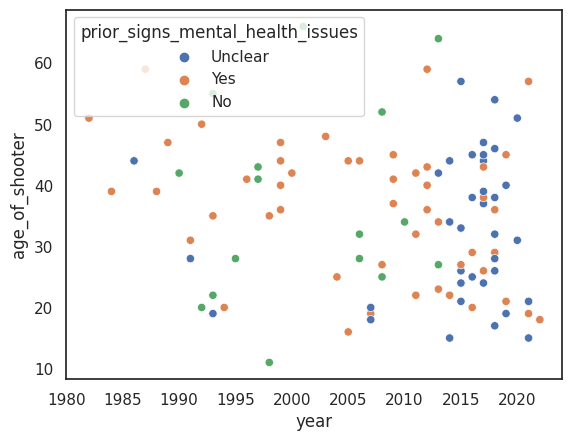

In [ ]:
sns.scatterplot(x=df_ms['year'], y=df_ms['age_of_shooter'], hue=df_ms['prior_signs_mental_health_issues'])

### Mapa cloropletico

Se llevó a cabo un mapa cloroplético para visualizar los estados en los que se han presentado más tiroteos en masa. El valor máximo fue de 17 tiroteos en California y el minimo fue de 0 en 12 estados, incluyendo Wyoming y Montana.

In [ ]:
df_ms[['city', 'state']] = df_ms['location'].str.split(', ', expand=True)
df_ms.head()

,case,location,summary,total_victims,location.1,age_of_shooter,prior_signs_mental_health_issues,mental_health_details,race,gender,year,city,state
0,Uvalde elementary school massacre,"Uvalde, Texas",DETAILS PENDING,0,School,18,Unclear,-,Unclear,M,2022,Uvalde,Texas
1,Buffalo supermarket massacre,"Buffalo, New York","Payton S. Gendron, 18, committed a racially mo...",13,Workplace,18,Yes,previous threats and a mental health evaluatio...,White,M,2022,Buffalo,New York
3,Oxford High School shooting,"Oxford, Michigan","Ethan Crumbley, a 15-year-old student at Oxfor...",11,School,15,Unclear,-,Unclear,M,2021,Oxford,Michigan
4,San Jose VTA shooting,"San Jose, California","Samuel Cassidy, 57, a Valley Transportation Au...",9,Workplace,57,Yes,"Perpetrator had a history of depression, angry...",Unclear,M,2021,San Jose,California
5,FedEx warehouse shooting,"Indianapolis, Indiana","Brandon Scott Hole, 19, opened fire around 11 ...",15,Workplace,19,Yes,Perpetrator had been reported to police in 202...,White,M,2021,Indianapolis,Indiana


In [ ]:
df_state = pd.DataFrame(df_ms['state'].value_counts())
df_state.rename(columns={'state': 'count'}, inplace=True)
df_state.head()

,count
California,17
Florida,9
Texas,7
Washington,7
New York,5


In [ ]:
pd.to_numeric(df_state['count'], errors='coerce')

California        17
Florida            9
Texas              7
Washington         7
New York           5
Colorado           5
Wisconsin          5
Pennsylvania       5
Illinois           4
Ohio               3
Maryland           3
Georgia            3
Michigan           3
Missouri           2
Kentucky           2
Tennessee          2
South Carolina     2
Minnesota          2
Connecticut        2
North Carolina     2
Arkansas           1
Iowa               1
Hawaii             1
Massachusetts      1
Mississippi        1
Utah               1
Nebraska           1
Kansas             1
Arizona            1
Nevada             1
D.C.               1
Oregon             1
Lousiana           1
Virginia           1
Indiana            1
Oklahoma           1
Name: count, dtype: int64

In [ ]:
df_state ['state_2'] = ['CA', 'FL', 'TX', 'WA', 'PA', 'NY', 'CO', 'WI', 'IL', 'CT', 'MD', 'OH', 'GA', 'MI', 'MO', 'TN', 'OR', 'SC', 'MN', 'NC', 'KY', 'AR', 'NE', 'HI', 'IA', 'MA',  'MS', 'UT', 'KS', 'AZ', 'NV', 'WA', 'LA', 'VA', 'IN', 'OK']
df_state.head()

,count,state_2
California,17,CA
Florida,9,FL
Texas,7,TX
Washington,7,WA
New York,5,PA


In [ ]:
states_geojson = 'https://github.com/beduExpert/B2-Analisis-de-Datos-con-Python-2020/raw/master/Datasets/us_states.json'

m = folium.Map(location=[48, -102], zoom_start=3, width='60%', height='60%')

folium.Choropleth(
    geo_data=states_geojson,
    data=df_state,
    columns=['state_2', 'count'],
    key_on='feature.id',
    # Opcionales
    legend_name="Incidencia de tiroteos en masa en EUA",
    fill_color="YlGn",
    name="tiroteos"
).add_to(m)

folium.LayerControl().add_to(m)

m

## 8. Procesamiento de Lenguaje Natural



###Patrones Regex para limpiar tus datos estructurados.

Con la finalidad de limpiar los datos estructurados de las varables de caso y summary se utilizo los patrones de regex.

In [ ]:
grouped_by_case = df_ms.groupby('case')['summary'].max()

grouped_by_case

case
101 California Street shootings      Failed businessman Gian Luigi Ferri, 55, opene...
Accent Signage Systems shooting      Andrew Engeldinger, 36, upon learning he was b...
Air Force base shooting              Former airman Dean Allen Mellberg, 20, opened ...
Alturas tribal shooting              Cherie Lash Rhoades, 44, opened fire at the Ce...
Amish school shooting                Charles Carl Roberts, 32, shot 10 young girls ...
                                                           ...                        
Welding shop shooting                Junior high school teacher Carl Robert Brown, ...
Westroads Mall shooting              Robert A. Hawkins, 19, opened fire inside West...
Westside Middle School killings      Mitchell Scott Johnson, 13, and Andrew Douglas...
Xerox killings                       Byran Koji Uyesugi, 40, a Xerox service techni...
Yountville veterans home shooting    Army veteran Albert Cheung Wong, 36, stormed a...
Name: summary, Length: 106, dtype: obj

In [ ]:
grouped_by_case[grouped_by_case.str.contains('street', case=False)]

case
Fresno downtown shooting    Kori Ali Muhammad, 39, opened fire along a str...
Name: summary, dtype: object

In [ ]:
grouped_by_case[grouped_by_case.str.contains('[0-5]')]

case
101 California Street shootings      Failed businessman Gian Luigi Ferri, 55, opene...
Accent Signage Systems shooting      Andrew Engeldinger, 36, upon learning he was b...
Air Force base shooting              Former airman Dean Allen Mellberg, 20, opened ...
Alturas tribal shooting              Cherie Lash Rhoades, 44, opened fire at the Ce...
Amish school shooting                Charles Carl Roberts, 32, shot 10 young girls ...
                                                           ...                        
Welding shop shooting                Junior high school teacher Carl Robert Brown, ...
Westroads Mall shooting              Robert A. Hawkins, 19, opened fire inside West...
Westside Middle School killings      Mitchell Scott Johnson, 13, and Andrew Douglas...
Xerox killings                       Byran Koji Uyesugi, 40, a Xerox service techni...
Yountville veterans home shooting    Army veteran Albert Cheung Wong, 36, stormed a...
Name: summary, Length: 102, dtype: obj

In [ ]:
grouped_by_case[grouped_by_case.str.contains('[0-9]+[a-z]+', case=False)]

case
Capital Gazette shooting           Jarrod W. Ramos, 38, shot through the glass do...
Edgewood businees park shooting    Radee Labeeb Prince, 37, fatally shot three pe...
Gilroy garlic festival shooting    Santino William LeGan, 19, fired indiscriminat...
Oxford High School shooting        Ethan Crumbley, a 15-year-old student at Oxfor...
Xerox killings                     Byran Koji Uyesugi, 40, a Xerox service techni...
Name: summary, dtype: object

In [ ]:
grouped_by_case = grouped_by_case.str.lower()
grouped_by_case = grouped_by_case.str.strip()
grouped_by_case = grouped_by_case.str.replace('[^\w\s]', '')
grouped_by_case = grouped_by_case.str.replace('\d', '')
grouped_by_case = grouped_by_case.str.replace('\\n', '')
grouped_by_case = grouped_by_case.dropna()

grouped_by_case

<ipython-input-300-687206051c6d>:3: FutureWarning:

The default value of regex will change from True to False in a future version.

<ipython-input-300-687206051c6d>:4: FutureWarning:

The default value of regex will change from True to False in a future version.

<ipython-input-300-687206051c6d>:5: FutureWarning:

The default value of regex will change from True to False in a future version.



case
101 California Street shootings      failed businessman gian luigi ferri  opened fi...
Accent Signage Systems shooting      andrew engeldinger  upon learning he was being...
Air Force base shooting              former airman dean allen mellberg  opened fire...
Alturas tribal shooting              cherie lash rhoades  opened fire at the cedarv...
Amish school shooting                charles carl roberts  shot  young girls in a o...
                                                           ...                        
Welding shop shooting                junior high school teacher carl robert brown  ...
Westroads Mall shooting              robert a hawkins  opened fire inside westroads...
Westside Middle School killings      mitchell scott johnson  and andrew douglas gol...
Xerox killings                       byran koji uyesugi  a xerox service technician...
Yountville veterans home shooting    army veteran albert cheung wong  stormed a vet...
Name: summary, Length: 106, dtype: obj

###  Objeto Text con la librería nltk

Para analizar las palabras relevantes de la variable sumary se utilizo el objeto Text y se exploraron también las palabras que tengan contexto similar.

In [ ]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
tokenized = grouped_by_case.apply(nltk.word_tokenize)
tokenized

case
101 California Street shootings      [failed, businessman, gian, luigi, ferri, open...
Accent Signage Systems shooting      [andrew, engeldinger, upon, learning, he, was,...
Air Force base shooting              [former, airman, dean, allen, mellberg, opened...
Alturas tribal shooting              [cherie, lash, rhoades, opened, fire, at, the,...
Amish school shooting                [charles, carl, roberts, shot, young, girls, i...
                                                           ...                        
Welding shop shooting                [junior, high, school, teacher, carl, robert, ...
Westroads Mall shooting              [robert, a, hawkins, opened, fire, inside, wes...
Westside Middle School killings      [mitchell, scott, johnson, and, andrew, dougla...
Xerox killings                       [byran, koji, uyesugi, a, xerox, service, tech...
Yountville veterans home shooting    [army, veteran, albert, cheung, wong, stormed,...
Name: summary, Length: 106, dtype: obj

In [ ]:
all_words = tokenized.sum()
text = nltk.Text(all_words)

text

<Text: failed businessman gian luigi ferri opened fire throughout...>

In [ ]:
text.concordance('woman', lines=20)

Displaying 5 of 5 matches:
fire at an upscale nightclub after a woman rejected his advances he was later a
sson bay harbor inn before killing a woman outside who refused to give him her 
e opening fire outside and killing a woman he then drove to a winndixie superma
te residence after then carjacking a woman who was driving with a child and let
enver and fatally shot two men and a woman then left the store and drove away a


In [ ]:
text.similar('woman')

supervisor roommate felon coworker


In [ ]:
text.similar('women')

police people coworkers students runup


In [ ]:
text.concordance('man', lines=20)

Displaying 2 of 2 matches:
epartment store at the cascade mall a man was critically wounded in the shootin
red victims included a yearold girl a man in his s and sixyearold stephen romer


In [ ]:
text.common_contexts(['woman', 'man'])

No common contexts were found


In [ ]:
text.common_contexts(['students', 'school'])

No common contexts were found


In [ ]:
text.concordance('school', lines=20)

Displaying 12 of 12 matches:
led by police former lindhurst high school student eric houston angry about va
three students and a teacher at the school before surrendering to police after
ot five students at marysville high school including two of his cousins and th
anged to meet them for lunch in the school cafeteria by text fryberg was repor
erg was reportedly wellliked at the school and there was not believed to be an
ey a yearold student at oxford high school opened fire with a sig sauer mm pis
including shooting up an elementary school before being killed by law enforcem
s squad car to red lake senior high school and opened fire on the reservation 
tudent opened fire at santa fe high school with a shotgun and revolver owned b
f and additional gunfire inside the school pagourtzis reportedly had intended 
fore committing suicide junior high school teacher carl robert brown opened fi
dents and teachers as they left the school they were apprehended by police at 


In [ ]:
text.concordance('police', lines=20)

Displaying 20 of 55 matches:
fore he committed suicide inside as police pursued him andrew engeldinger upon
fore he was shot dead by a military police officer outside cherie lash rhoades
hours later after being cornered by police outside a gas station committed sui
ine who served in iraq killed three police offers responding to a call and wou
left victims dead including veteran police officer eric talley who was the fir
 on the scene alissa was wounded by police and taken into custody payton s gen
 mass murder before surrendering to police according to police further details
surrendering to police according to police further details pending former calt
tolen from work he was shot dead by police jarrod w ramos shot through the gla
m around pm to carry out his attack police quickly responding to the scene fou
efore he was shot and arrested by a police officer arcan cetin killed a teen g
re he died cetin was apprehended by police a few hours after the shooting whil
a navy service member a

In [ ]:
text.concordance('young', lines=20)

Displaying 1 of 1 matches:
her person charles carl roberts shot young girls in a oneroom schoolhouse in ba


In [ ]:
len(set(text))

1281

In [ ]:
len(set(text)) / len(text)

0.30645933014354065

### Objeto FreqDist de nltk

Para explorar las palabras y los bigramas para hacer un análisis estadístico de las palabras que mas se repiten, o con una cierta longitud.

In [ ]:
all_words = tokenized.sum()

In [ ]:
freq_dist = nltk.FreqDist(all_words)

print(freq_dist)

<FreqDist with 1281 samples and 4180 outcomes>


In [ ]:
freq_dist.most_common(50)

[('a', 212),
 ('the', 145),
 ('and', 135),
 ('in', 93),
 ('he', 86),
 ('at', 74),
 ('was', 68),
 ('to', 66),
 ('fire', 56),
 ('his', 56),
 ('police', 55),
 ('before', 54),
 ('shot', 53),
 ('of', 50),
 ('opened', 49),
 ('on', 38),
 ('by', 38),
 ('killed', 36),
 ('with', 35),
 ('after', 33),
 ('had', 31),
 ('an', 29),
 ('suicide', 29),
 ('then', 25),
 ('three', 24),
 ('former', 24),
 ('two', 23),
 ('as', 21),
 ('who', 21),
 ('himself', 20),
 ('later', 20),
 ('people', 20),
 ('scene', 20),
 ('inside', 19),
 ('shooting', 18),
 ('killing', 18),
 ('fatally', 18),
 ('committing', 17),
 ('for', 16),
 ('arrested', 16),
 ('being', 15),
 ('attack', 14),
 ('others', 14),
 ('that', 14),
 ('fired', 13),
 ('where', 13),
 ('employee', 13),
 ('from', 13),
 ('officer', 12),
 ('victims', 12)]

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
english_stop_words = stopwords.words('english')

all_words_except_stop_words = [word for word in all_words if word not in english_stop_words]

freq_dist = nltk.FreqDist(all_words_except_stop_words)

In [ ]:
freq_dist.most_common(50)

[('fire', 56),
 ('police', 55),
 ('shot', 53),
 ('opened', 49),
 ('killed', 36),
 ('suicide', 29),
 ('three', 24),
 ('former', 24),
 ('two', 23),
 ('later', 20),
 ('people', 20),
 ('scene', 20),
 ('inside', 19),
 ('shooting', 18),
 ('killing', 18),
 ('fatally', 18),
 ('committing', 17),
 ('arrested', 16),
 ('attack', 14),
 ('others', 14),
 ('fired', 13),
 ('employee', 13),
 ('officer', 12),
 ('victims', 12),
 ('school', 12),
 ('went', 11),
 ('dead', 11),
 ('law', 11),
 ('enforcement', 11),
 ('wounded', 11),
 ('officers', 11),
 ('including', 11),
 ('committed', 10),
 ('rampage', 10),
 ('four', 10),
 ('building', 9),
 ('according', 9),
 ('workplace', 9),
 ('responding', 9),
 ('car', 9),
 ('five', 9),
 ('reportedly', 9),
 ('another', 8),
 ('fled', 8),
 ('also', 8),
 ('apprehended', 8),
 ('home', 8),
 ('died', 8),
 ('death', 8),
 ('yearold', 8)]

In [ ]:
# Conteo de la palabra school y porcentaje de aparición

print(f'{(100 * freq_dist["school"] / len(all_words_except_stop_words)):.3f}%')

0.462%


In [ ]:
# Conteo de la palabra workplace y porcentaje de aparición

print(f'{(100 * freq_dist["workplace"] / len(all_words_except_stop_words)):.3f}%')

0.347%


In [ ]:
# Conteo de la palabra workplace y porcentaje de aparición

print(f'{(100 * freq_dist["women"] / len(all_words_except_stop_words)):.3f}%')

0.231%


In [ ]:
# Conteo de la palabra workplace y porcentaje de aparición

print(f'{(100 * freq_dist["men"] / len(all_words_except_stop_words)):.3f}%')

0.039%


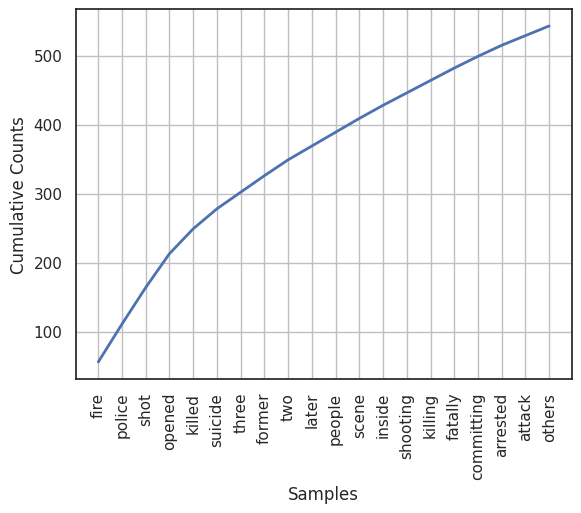

In [ ]:
freq_dist.plot(20, cumulative=True);

In [ ]:
# Palabras que sólo aparecen una sola vez

freq_dist.hapaxes()[:20]

['businessman',
 'gian',
 'luigi',
 'ferri',
 'engeldinger',
 'upon',
 'learning',
 'owner',
 'airman',
 'dean',
 'mellberg',
 'fairchild',
 'air',
 'force',
 'base',
 'cherie',
 'lash',
 'cedarville',
 'rancheria',
 'tribal']

In [ ]:
# Palabras largas

unique = set(all_words_except_stop_words)
unique_series = pd.Series(list(unique))

unique_series

0         failing
1         cheeses
2             sum
3          really
4          bowers
          ...    
1189     training
1190         roof
1191        ferri
1192      oneyear
1193    harassing
Length: 1194, dtype: object

In [ ]:
unique_series[unique_series.str.len() > 15]

89    indiscriminately
dtype: object

In [ ]:
# Palabras largas que son frecuentes

larger_than_10 = unique_series.str.len() > 7
is_frequent = unique_series.apply(lambda x: freq_dist[x] > 7)

unique_series[larger_than_10 & is_frequent]

9          shooting
105        arrested
114      reportedly
123       including
182     enforcement
252        building
516       workplace
639      responding
814      committing
817       committed
837     apprehended
1025      according
1098       standoff
1143       officers
1178       employee
dtype: object

In [ ]:
freq_dist_lengths = nltk.FreqDist([len(w) for w in all_words_except_stop_words])
freq_dist_lengths.most_common()

[(6, 534),
 (7, 441),
 (4, 390),
 (5, 368),
 (8, 312),
 (9, 166),
 (3, 131),
 (10, 125),
 (11, 67),
 (12, 23),
 (2, 19),
 (13, 9),
 (1, 5),
 (14, 5),
 (16, 1)]

In [ ]:
freq_dist_lengths.max()

6

In [ ]:
freq_dist_lengths[5]

368

In [ ]:
#Proporción del total de palabras tiene longitud de 5

freq_dist_lengths.freq(7)

0.16987673343605547

### Visualizaciones de conteos de frecuencias utilizando gráficas de barras

In [ ]:
import seaborn as sns

In [ ]:
most_common_20 = np.array(list(map(lambda x: list(x), freq_dist.most_common(20))))
most_common_20

array([['fire', '56'],
       ['police', '55'],
       ['shot', '53'],
       ['opened', '49'],
       ['killed', '36'],
       ['suicide', '29'],
       ['three', '24'],
       ['former', '24'],
       ['two', '23'],
       ['later', '20'],
       ['people', '20'],
       ['scene', '20'],
       ['inside', '19'],
       ['shooting', '18'],
       ['killing', '18'],
       ['fatally', '18'],
       ['committing', '17'],
       ['arrested', '16'],
       ['attack', '14'],
       ['others', '14']], dtype='<U21')

In [ ]:
df_most_common_20 = pd.DataFrame(most_common_20)
df_most_common_20.columns = ["word","freq"]
df_most_common_20.head(2)

,word,freq
0,fire,56
1,police,55


In [ ]:
df_most_common_20['freq'] = pd.to_numeric(df_most_common_20['freq'], errors='coerce')

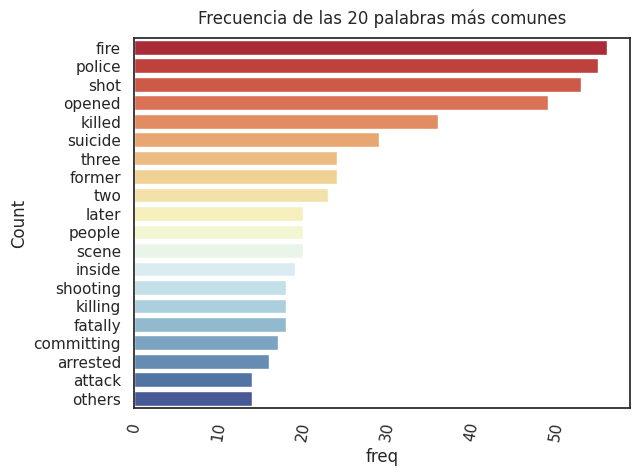

In [ ]:
fig = plt.figure()

ax = fig.add_subplot()

sns.barplot(data = df_most_common_20, x = "freq", y = "word", ax=ax, palette='RdYlBu');

ax.set_title('Frecuencia de las 20 palabras más comunes', pad=10)

ax.set_ylabel('Count')

ax.tick_params(axis='x', rotation=80)

### Distribuciones de frecuencias de las longitudes de las palabras

<ipython-input-339-c54da5b468ac>:2: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




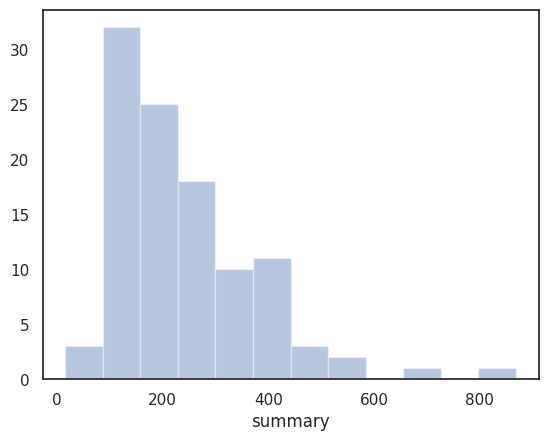

In [ ]:
sentence_lengths = grouped_by_case.apply(lambda x: len(x))
sns.distplot(sentence_lengths, kde=False, norm_hist=False);

<ipython-input-340-8fd9bd35a209>:2: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




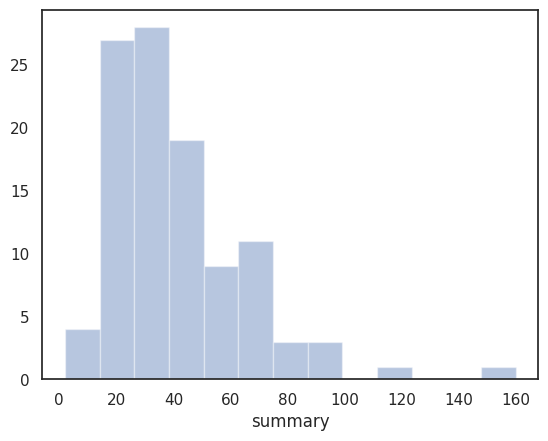

In [ ]:
num_of_words = grouped_by_case.str.split(' ').str.len()
sns.distplot(num_of_words, kde=False, norm_hist=False);

### Nubes de palabras

Se hizo una visualizacion de nubes para conocer los temas más importantes de los datos.

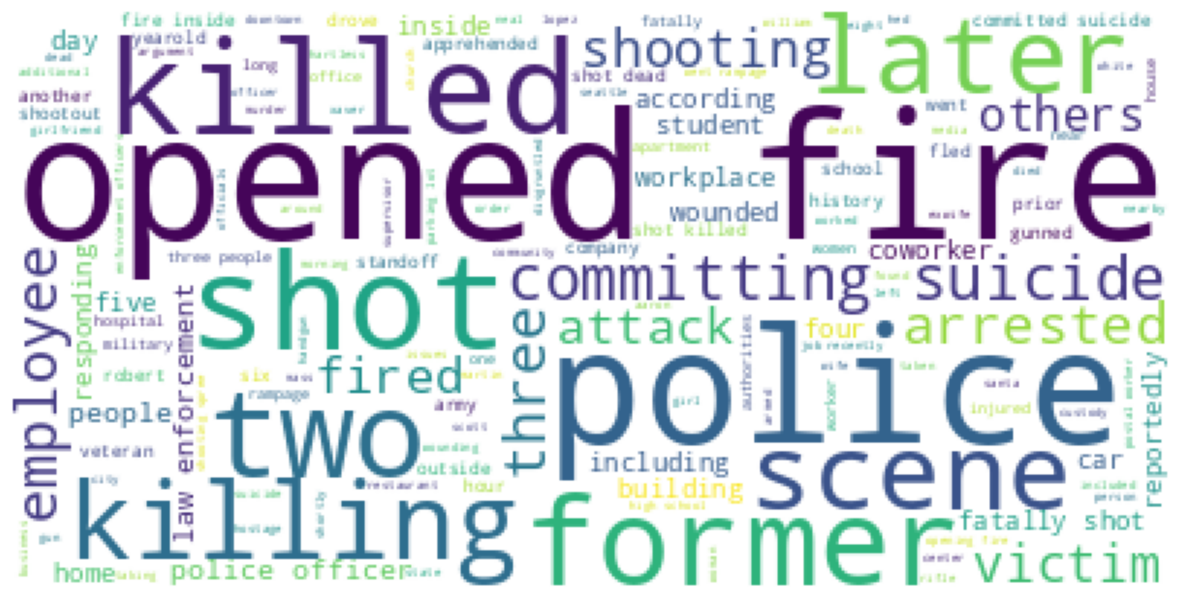

In [ ]:
from wordcloud import WordCloud

worldcloud = WordCloud(max_font_size=100, background_color='white').generate(
    ' '.join(all_words_except_stop_words)
)

plt.figure(figsize=(15,15))
plt.imshow(worldcloud)
plt.axis("off")
plt.show()


# Introducción a machine learning

###Clasificación no supervisada

In [ ]:
from sklearn.cluster import KMeans
k_means = KMeans(n_clusters=6, max_iter=10000)
k_means.fit(df_ms[['total_victims', 'year']])

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



KMeans(max_iter=10000, n_clusters=6)

In [ ]:
centers = k_means.cluster_centers_

centers

array([[   8.76190476, 2009.71428571],
       [  22.83333333, 1991.33333333],
       [  17.29411765, 2015.58823529],
       [   5.80555556, 2017.55555556],
       [  10.07142857, 2000.07142857],
       [   9.75      , 1990.33333333]])

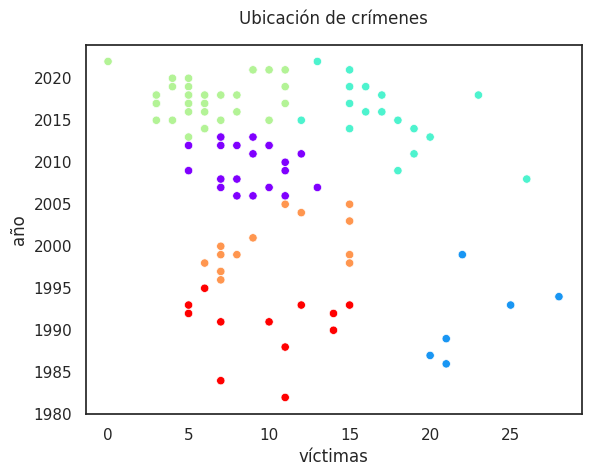

In [ ]:
clasificaciones = k_means.predict(df_ms[['total_victims', 'year']])
fig = plt.figure()
ax = fig.add_subplot()

ax.set_title('Ubicación de crímenes', pad=15)
ax.set_xlabel('víctimas')
ax.set_ylabel('año')

sns.scatterplot(x=df_ms['total_victims'], y=df_ms['year'], hue=clasificaciones, palette='rainbow');
ax.get_legend().remove()


###Regresión Logística

In [ ]:
columnas_string = df_ms.select_dtypes(include='object').columns
df_sin_string = df_ms.drop(columns=columnas_string)
print(df_sin_string)

     total_victims  age_of_shooter  year
0                0              18  2022
1               13              18  2022
3               11              15  2021
4                9              57  2021
5               15              19  2021
..             ...             ...   ...
123             20              59  1987
124             21              44  1986
125             41              41  1984
126              7              39  1984
127             11              51  1982

[124 rows x 3 columns]


In [ ]:
x = df_sin_string.drop(columns=['year'])
y = df_sin_string['year']

In [ ]:
df_sin_string['total_victims'] = pd.to_numeric(df_sin_string['total_victims'])
df_sin_string['year'] = pd.to_numeric(df_sin_string['year'])
df_sin_string['age_of_shooter'] = pd.to_numeric(df_sin_string['age_of_shooter'])

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
logreg = LogisticRegression()

In [ ]:
logreg.fit(X_train, y_train)

ValueError: ignored

In [ ]:
y_pred = logreg.predict(X_test)

y_pred

array([2018, 2018, 1993, 2018, 2018, 1993, 2017, 2017, 2017, 2017, 2017,
       2018, 2017, 2018, 2018, 1989, 2018, 2017, 2017, 2018, 2017, 2017,
       2017, 1993, 2018, 1993, 2018, 2018, 2017, 2017, 1993, 1993])

In [ ]:
logreg.score(X_test, y_test)

TypeError: ignored

Por el dato obtenido podemos decir que el rendimiento es de 6% para datos nuevos.

### Matriz de confusión

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
logreg = LogisticRegression(max_iter=10000)
logreg.fit(X_train, y_train)

ValueError: ignored

In [ ]:
from sklearn import metrics
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)

cnf_matrix

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

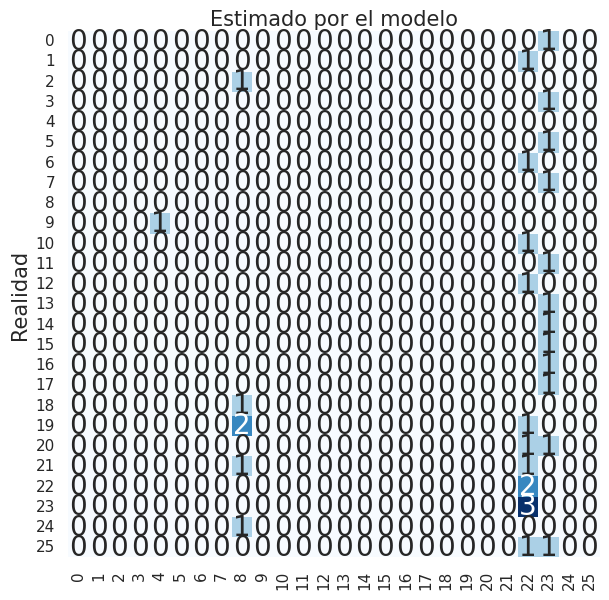

In [ ]:
class_names=[0,1] # name  of classes
fig, ax = plt.subplots(figsize=(6, 6))
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="Blues" ,fmt='g', cbar=False, annot_kws={"size": 20})
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.ylabel('Realidad', fontsize=15, y=0.5)
plt.xlabel('Estimado por el modelo', fontsize=15)